In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_raw = pd.read_csv("/content/electricity.gui")
print(df_raw.shape)
df_raw.head()

(29297, 18)


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,NaN,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,NaN,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,NaN,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,NaN,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,NaN,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [ ]:
df = df_raw.copy()

# Parse datetime
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

# Identify non-numeric columns (besides DateTime)
non_numeric = [c for c in df.columns if df[c].dtype == 'object' and c != 'DateTime']
print("Non-numeric columns:", non_numeric)

# Coerce everything except DateTime & Holiday (text) to numeric
protect = {'DateTime', 'Holiday'}
num_candidates = [c for c in df.columns if c not in protect]
for c in num_candidates:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.info()

Non-numeric columns: ['Holiday', 'ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29297 entries, 0 to 29296
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                11635 non-null  datetime64[ns]
 1   Holiday                 1248 non-null   object        
 2   HolidayFlag             29297 non-null  int64         
 3   DayOfWeek               29297 non-null  int64         
 4   WeekOfYear              29297 non-null  int64         
 5   Day                     29297 non-null  int64         
 6   Month                   29297 non-null  int64         
 7   Year                    29297 non-null  int64         
 8   PeriodOfDay             29297 non-null  int64         
 9   ForecastWindProduction  29292 non-null  f

In [ ]:
# Drop rows with missing target
TARGET = 'SMPEA'
df = df.dropna(subset=[TARGET]).copy()

# Fill categorical columns (including 'Holiday' if present)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df.loc[:, col] = df[col].fillna('None')

# Fill numeric columns with mean
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df.loc[:, col] = df[col].fillna(df[col].mean())

# Drop duplicate timestamps if any (keep first)
df = df.sort_values('DateTime').drop_duplicates(subset=['DateTime'], keep='first')

# Check
print(df.isnull().sum().sum(), "missing values remaining")
df.head(3)


1 missing values remaining


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,2011-01-11 00:00:00,None,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.0,9.3,600.71,356.0,3159.60,54.32
1,2011-01-11 00:30:00,None,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.0,11.1,605.42,317.0,2973.01,54.23
2,2011-01-11 01:00:00,None,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.0,11.1,589.97,311.0,2834.00,54.23


In [ ]:
# Outlier Handling using IQR method
import numpy as np

# Only apply to numeric columns except the target
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns if col != TARGET]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers instead of removing
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

print("Outlier capping completed.")

Outlier capping completed.


In [ ]:
# Time parts
df['Hour']       = df['DateTime'].dt.hour
df['Day']        = df['DateTime'].dt.day
df['Month']      = df['DateTime'].dt.month
df['Year']       = df['DateTime'].dt.year
df['DayOfWeek']  = df['DateTime'].dt.dayofweek  # 0=Mon
df['IsWeekend']  = (df['DayOfWeek'] >= 5).astype(int)

# Domain-ish flags
df['IsNight']    = df['Hour'].apply(lambda h: 1 if (h < 6 or h >= 22) else 0)
df['IsPeakHour'] = df['Hour'].apply(lambda h: 1 if (7 <= h <= 10) or (17 <= h <= 20) else 0)

# Optional: cyclical encoding for Hour
df['Hour_sin'] = np.sin(2*np.pi*df['Hour']/24)
df['Hour_cos'] = np.cos(2*np.pi*df['Hour']/24)

# Lags of target (avoid leakage!)
for lag in [1, 2, 48]:  # 48 ≈ one day if 30-min freq
    df[f'{TARGET}_lag{lag}'] = df[TARGET].shift(lag)

# Rolling means of target
df[f'{TARGET}_roll_6']  = df[TARGET].rolling(6, min_periods=1).mean()   # ~3 hours
df[f'{TARGET}_roll_48'] = df[TARGET].rolling(48, min_periods=1).mean()  # ~1 day

# Drop initial rows that have NaNs due to lagging
df = df.dropna().reset_index(drop=True)
df.head(3)

,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2,Hour,IsWeekend,IsNight,IsPeakHour,Hour_sin,Hour_cos,SMPEA_lag1,SMPEA_lag2,SMPEA_lag48,SMPEA_roll_6,SMPEA_roll_48
0,2011-01-12 00:00:00,None,0,2.0,48,12.0,1.0,2011.0,0,804.2,3878.03,58.21,5.0,18.5,451.45,949.0,3401.52,52.58,0.0,0,1,0,0.000000,1.000000,44.90,45.14,49.26,47.648333,60.278125
1,2011-01-12 00:30:00,None,0,2.0,48,12.0,1.0,2011.0,1,757.1,3647.08,44.27,5.0,18.5,453.76,943.0,3237.36,52.58,0.0,0,1,0,0.000000,1.000000,58.21,44.90,49.26,47.318333,60.174167
2,2011-01-12 01:00:00,None,0,2.0,48,12.0,1.0,2011.0,2,708.3,3506.46,44.27,5.0,20.4,462.87,790.0,3143.25,52.17,1.0,0,1,0,0.258819,0.965926,44.27,58.21,49.10,46.988333,60.073542


# ***Visualizations***

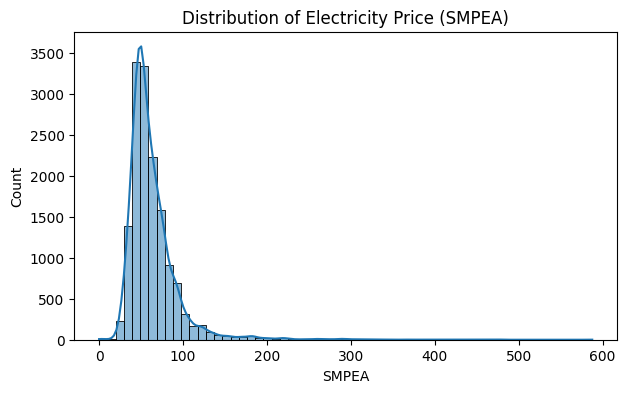

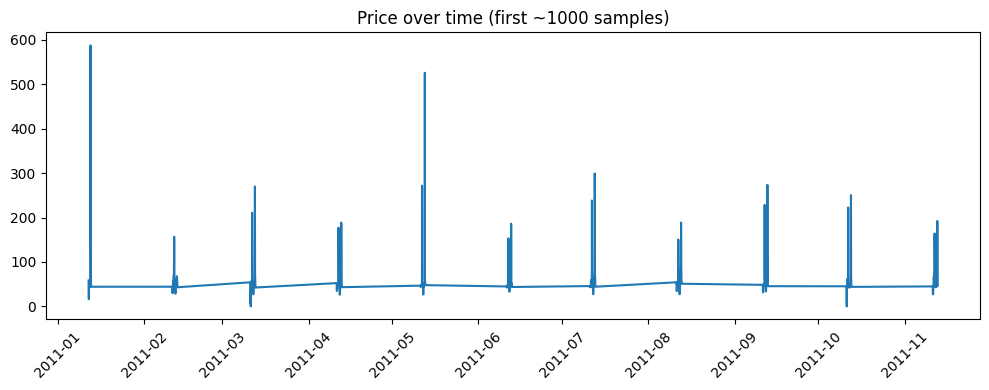

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(df[TARGET], bins=60, kde=True)
plt.title('Distribution of Electricity Price (SMPEA)')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df['DateTime'].iloc[:1000], df[TARGET].iloc[:1000])
plt.title('Price over time (first ~1000 samples)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

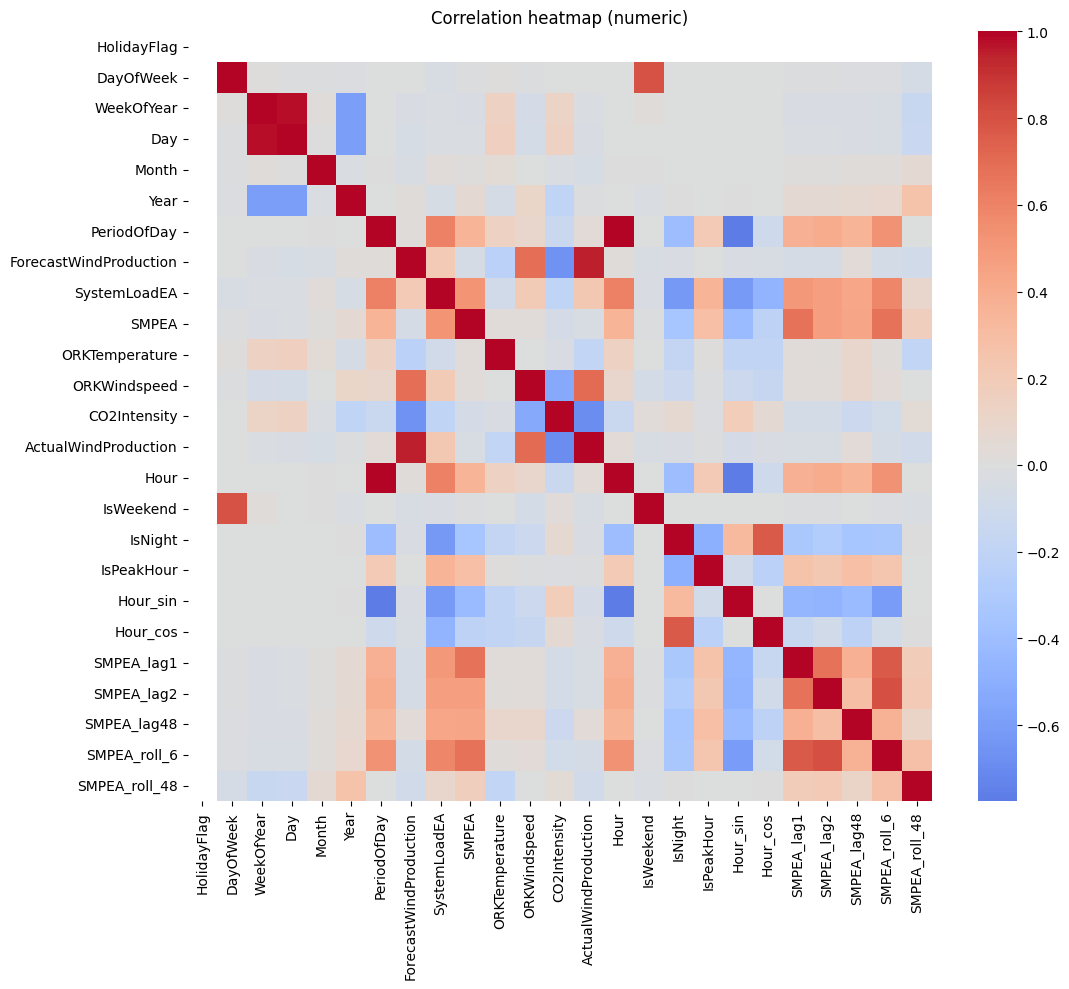

,Feature,MI_Score
19,SMPEA_lag1,2.953645
20,SMPEA_lag2,2.013807
2,WeekOfYear,1.588118
21,SMPEA_lag48,1.311694
22,SMPEA_roll_6,1.204760
3,Day,1.141771
4,Month,1.037292
1,DayOfWeek,0.779143
9,ORKTemperature,0.628229
8,SystemLoadEA,0.483736


In [ ]:
# Choose candidate features (drop alternate versions if present)
drop_cols = {'DateTime','Holiday','SMPEP2','SystemLoadEP2'} & set(df.columns)
base_cols = [c for c in df.columns if c not in drop_cols]

# Quick correlation heatmap (numeric only)
corr = df[base_cols].select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric)')
plt.show()

# Mutual information with target
feature_candidates = [c for c in base_cols if c != TARGET and pd.api.types.is_numeric_dtype(df[c])]
mi = mutual_info_regression(df[feature_candidates], df[TARGET], random_state=RANDOM_STATE)
mi_df = pd.DataFrame({'Feature': feature_candidates, 'MI_Score': mi}).sort_values('MI_Score', ascending=False)
mi_df.head(15)

In [ ]:
# Keep only numeric features for VIF
X_vif = df[feature_candidates].copy()

# Add constant then compute VIF (skip constant in report)
X_with_const = add_constant(X_vif)
vif_vals = [variance_inflation_factor(X_with_const.values, i+1) for i in range(X_vif.shape[1])]
vif_df = pd.DataFrame({'Feature': X_vif.columns, 'VIF': vif_vals}).sort_values('VIF', ascending=False)
vif_df.head(20)

,Feature,VIF
13,Hour,770.185369
6,PeriodOfDay,768.395308
3,Day,23.251054
2,WeekOfYear,23.122570
12,ActualWindProduction,11.474522
7,ForecastWindProduction,10.783817
22,SMPEA_roll_6,5.466525
15,IsNight,4.792396
8,SystemLoadEA,4.569571
18,Hour_cos,4.469106


In [ ]:
# Start from high-signal features; keep both raw + engineered where useful
keep = [
    'HolidayFlag', 'DayOfWeek', 'Month', 'IsWeekend', 'IsNight', 'IsPeakHour',
    'Hour', 'Hour_sin', 'Hour_cos',
    'ForecastWindProduction', 'ActualWindProduction',
    'SystemLoadEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity',
    f'{TARGET}_lag1', f'{TARGET}_lag2', f'{TARGET}_lag48',
    f'{TARGET}_roll_6', f'{TARGET}_roll_48'
]
# Keep only those that exist (some datasets may lack a few)
keep = [c for c in keep if c in df.columns]

X = df[keep].copy()
y = df[TARGET].copy()
X.shape, y.shape, keep[:10]

((11587, 20),
 (11587,),
 ['HolidayFlag',
  'DayOfWeek',
  'Month',
  'IsWeekend',
  'IsNight',
  'IsPeakHour',
  'Hour',
  'Hour_sin',
  'Hour_cos',
  'ForecastWindProduction'])

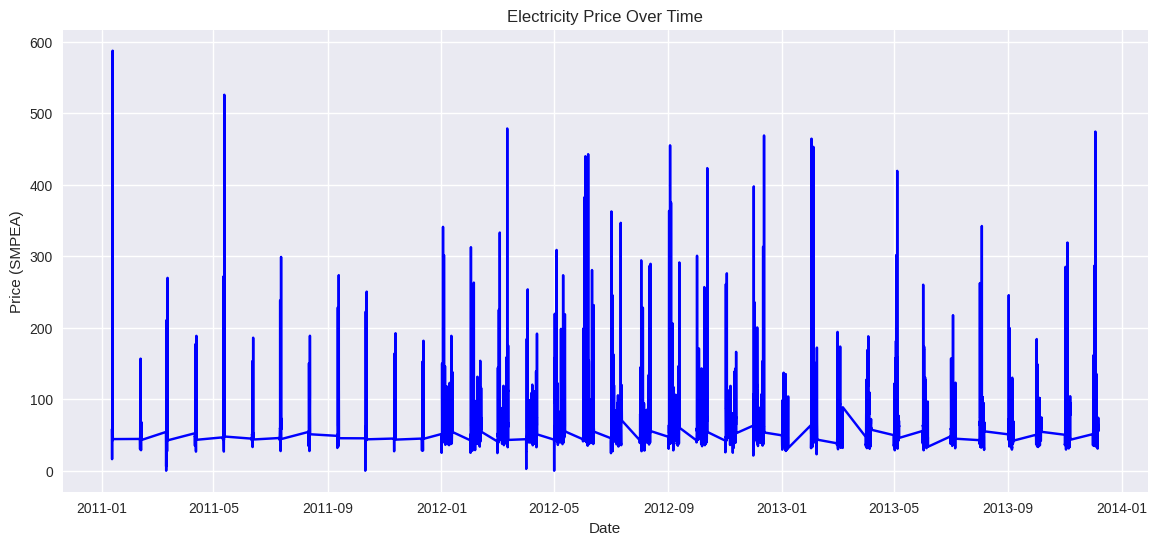

In [ ]:
# Ensure DateTime is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Add useful time features if not already present
df['Month'] = df['DateTime'].dt.month
df['DayOfWeek'] = df['DateTime'].dt.day_name()

plt.style.use('seaborn-v0_8')

# 1. Price vs Time
plt.figure(figsize=(14,6))
plt.plot(df['DateTime'], df['SMPEA'], color='blue')
plt.title('Electricity Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (SMPEA)')
plt.grid(True)
plt.show()

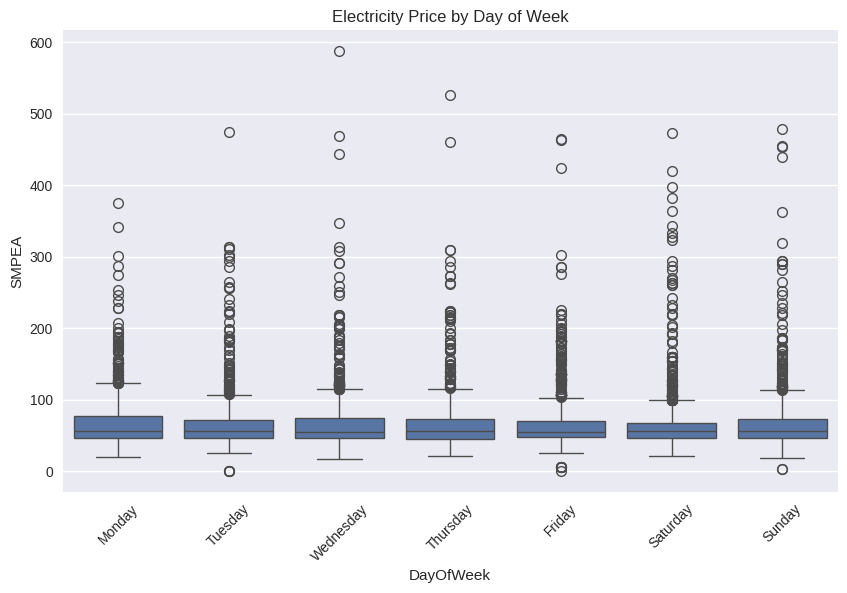

In [ ]:
# 2. Boxplot: Price by Day of Week
plt.figure(figsize=(10,6))
sns.boxplot(x='DayOfWeek', y='SMPEA', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Electricity Price by Day of Week')
plt.xticks(rotation=45)
plt.show()

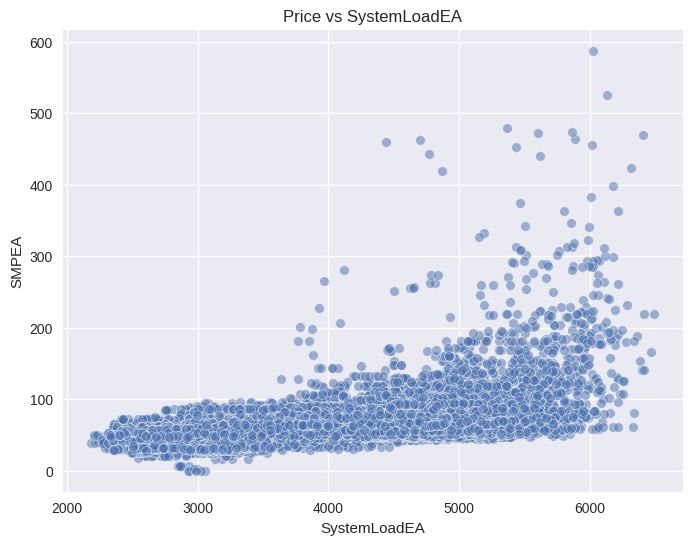

In [ ]:
# 3. Scatter Plot: Price vs. Demand (adjust 'Demand' column name if needed)
if 'SystemLoadEA' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='SystemLoadEA', y='SMPEA', data=df, alpha=0.5)
    plt.title('Price vs SystemLoadEA')
    plt.show()

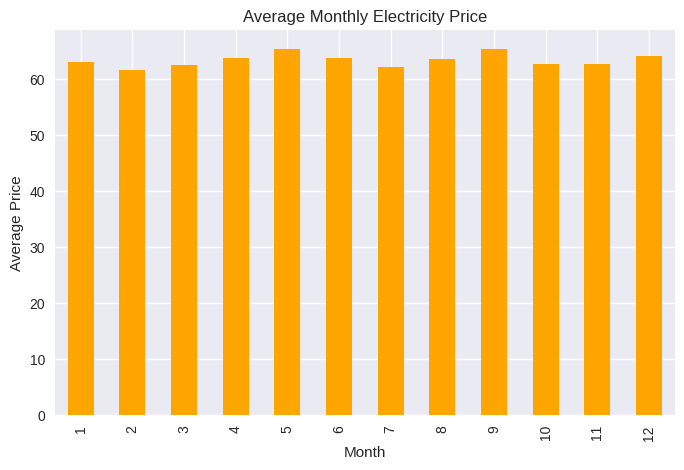

In [ ]:
# 4. Monthly Average Price
monthly_avg = df.groupby('Month')['SMPEA'].mean()
plt.figure(figsize=(8,5))
monthly_avg.plot(kind='bar', color='orange')
plt.title('Average Monthly Electricity Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.show()

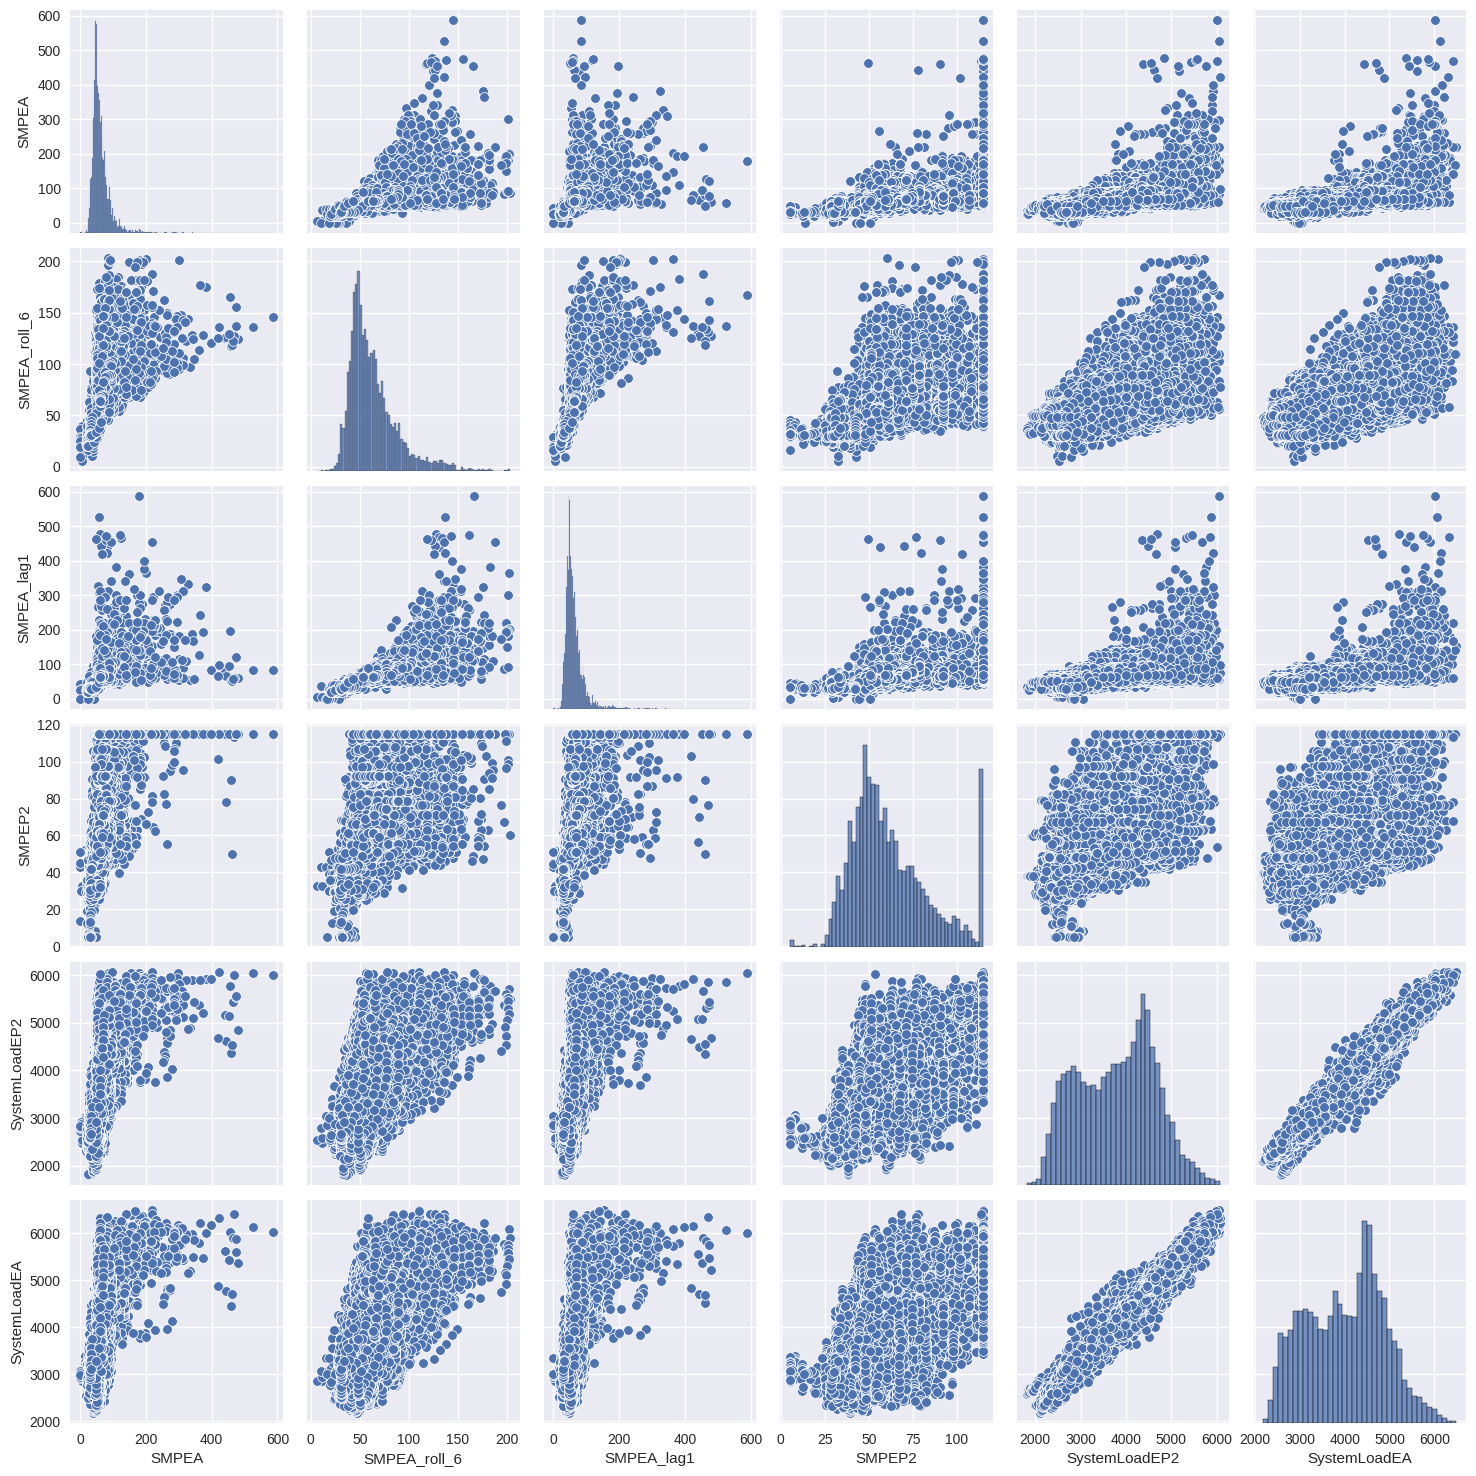

In [ ]:
# 5. Pairplot for top numerical features (pick top 5 correlated with price)
numeric_cols = df.select_dtypes(include=['float64','int64']).columns
top_corr_features = df[numeric_cols].corr()['SMPEA'].abs().sort_values(ascending=False).head(6).index
sns.pairplot(df[top_corr_features])
plt.show()

In [ ]:
# Use chronological split (last 20% as test)
split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.shape, X_test.shape

((9269, 20), (2318, 20))

# ***Final Summary***

📌 Basic Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14928 entries, 0 to 14927
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                14928 non-null  datetime64[ns]
 1   Holiday                 14928 non-null  object        
 2   HolidayFlag             14928 non-null  int64         
 3   DayOfWeek               14928 non-null  object        
 4   WeekOfYear              14928 non-null  float64       
 5   Day                     14928 non-null  float64       
 6   Month                   14928 non-null  int32         
 7   Year                    14928 non-null  float64       
 8   PeriodOfDay             14928 non-null  int64         
 9   ForecastWindProduction  14928 non-null  float64       
 10  SystemLoadEA            14928 non-null  float64       
 11  SMPEA                   14928 non-null  float64       
 12  ORKTemperature          

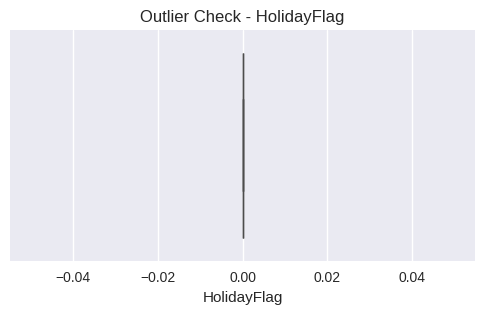

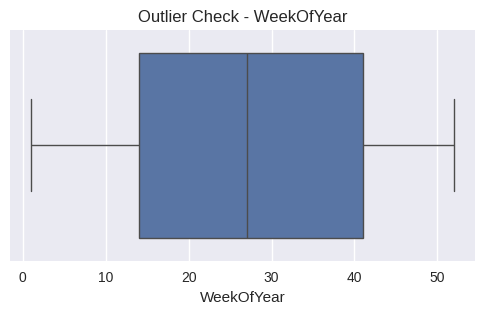

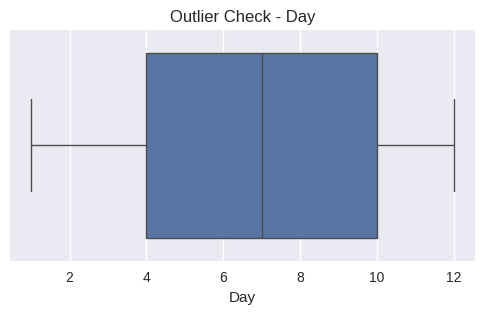

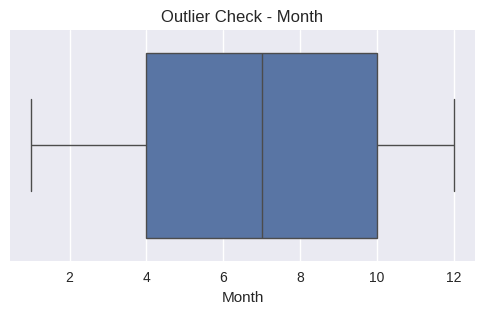

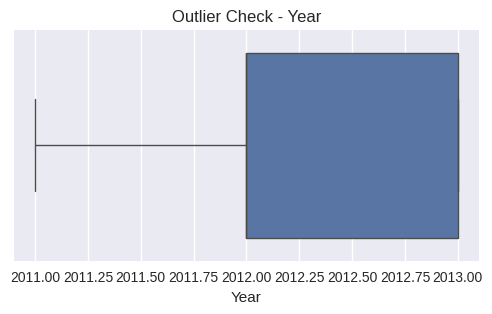

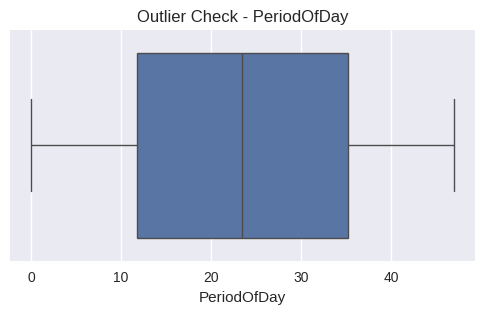

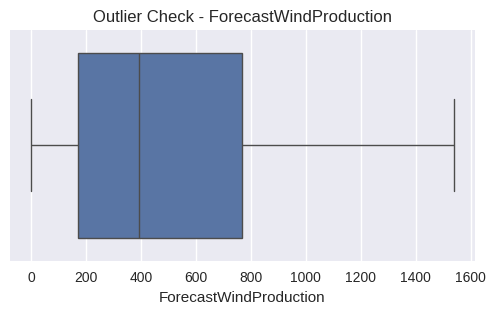

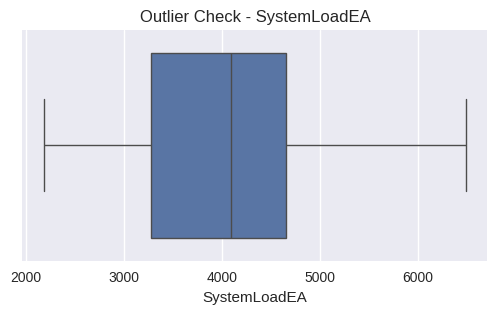

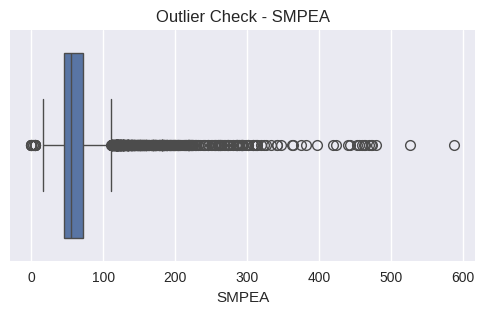

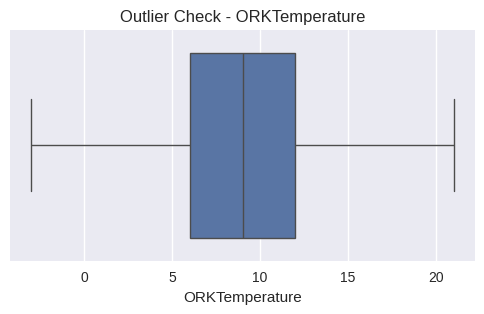

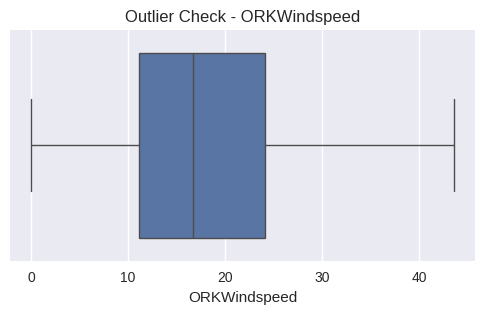

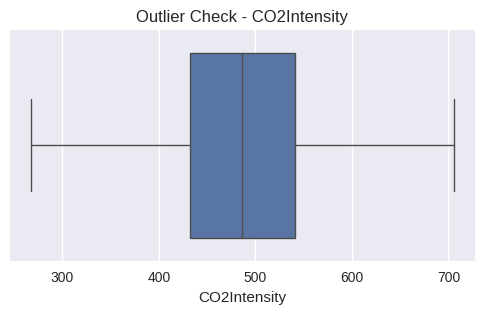

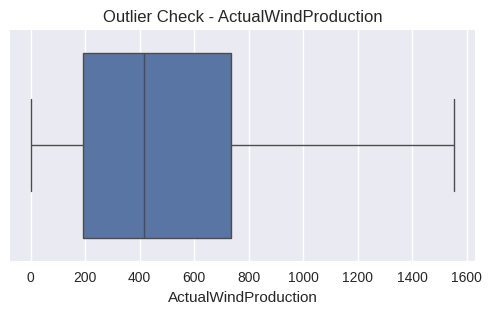

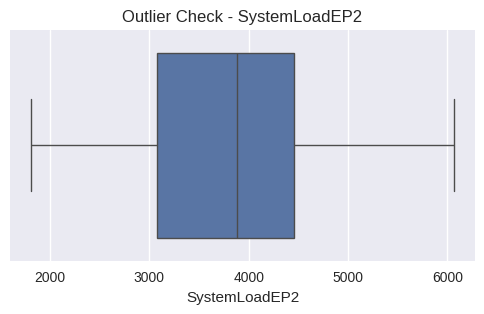

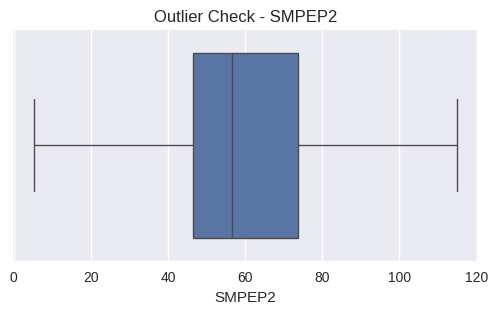

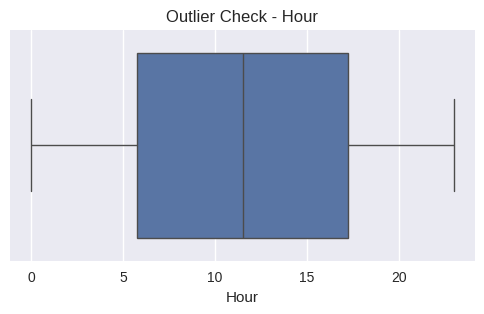

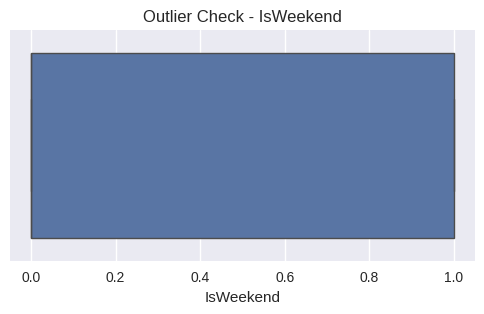

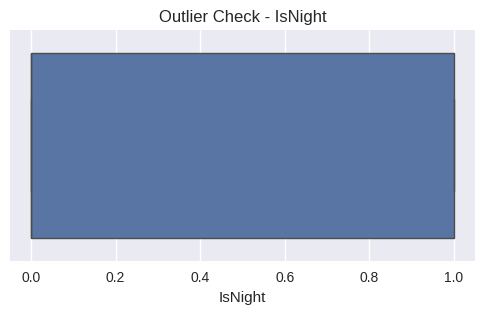

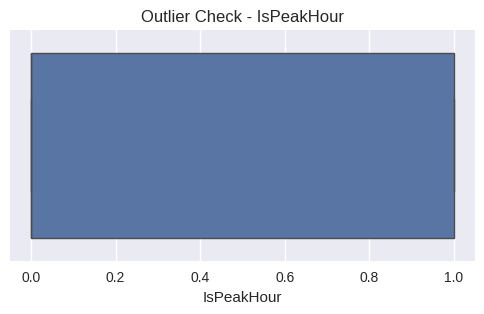

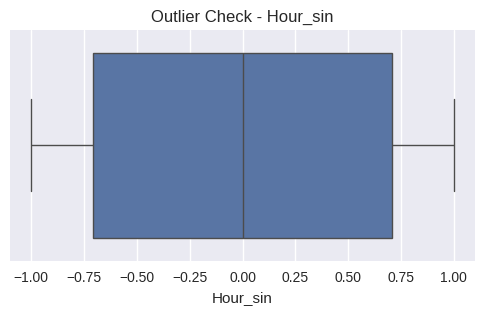

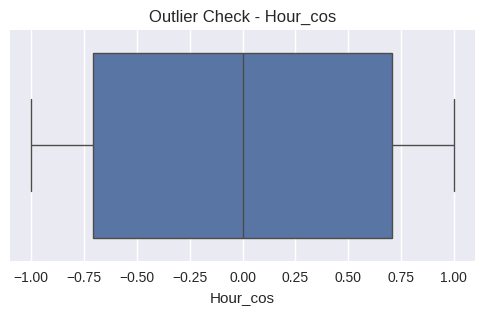

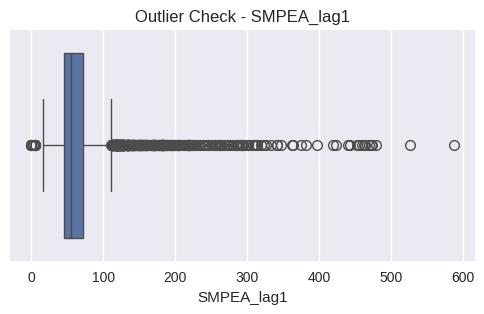

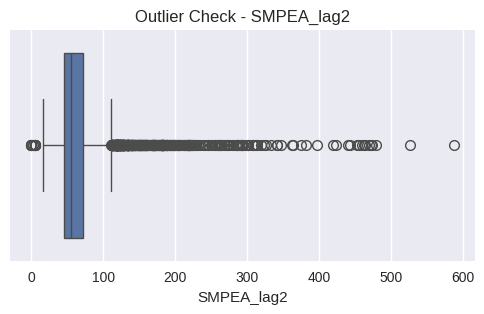

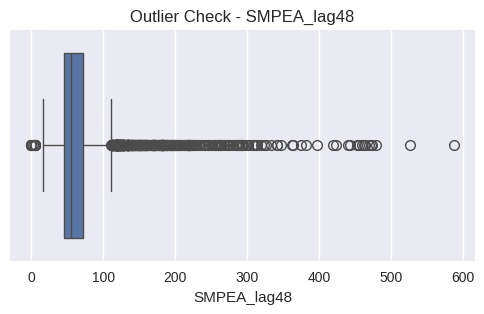

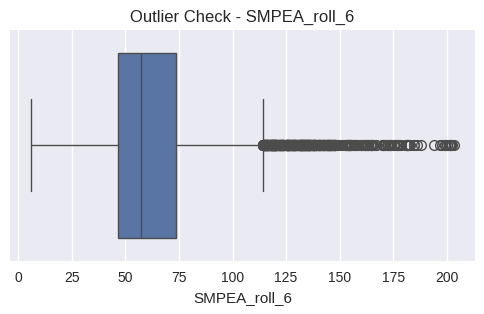

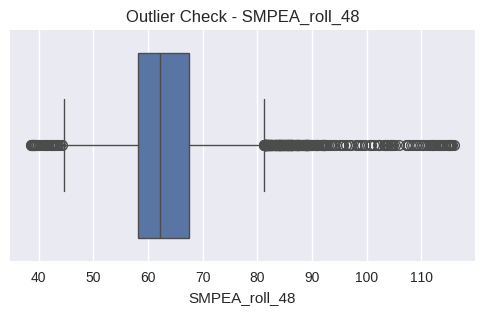


📊 Variance Inflation Factor (VIF):
                   Feature         VIF
0              HolidayFlag         NaN
1               WeekOfYear   29.199788
2                      Day   29.248298
3                    Month    1.035935
4                     Year    1.363393
5              PeriodOfDay  768.715043
6   ForecastWindProduction   11.675293
7             SystemLoadEA   39.982317
8           ORKTemperature    1.677537
9             ORKWindspeed    2.263127
10            CO2Intensity    2.262410
11    ActualWindProduction   12.669433
12           SystemLoadEP2   37.841277
13                  SMPEP2    2.073488
14                    Hour  770.583338
15               IsWeekend    1.016204
16                 IsNight    4.815651
17              IsPeakHour    1.748827
18                Hour_sin    4.511011
19                Hour_cos    4.628173
20              SMPEA_lag1    2.772116
21              SMPEA_lag2    3.063156
22             SMPEA_lag48    1.469695
23            SMPEA_roll_6  

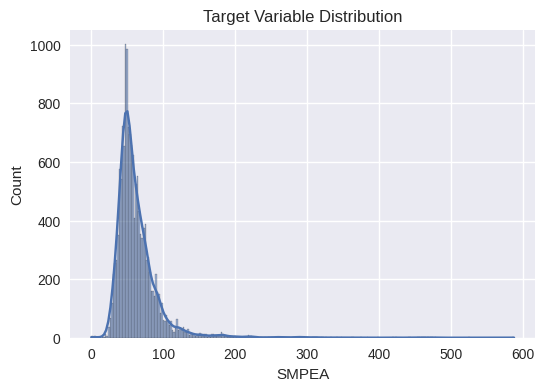


📈 Skewness of target: 4.577099281968813


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

print("📌 Basic Data Overview")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# 1. Missing Values Check
print("\n🔍 Missing Values Check:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found ✅")

# 2. Duplicate Check
duplicates = df.duplicated().sum()
print(f"\n🔍 Duplicates Found: {duplicates}" if duplicates > 0 else "\nNo duplicates found ✅")

# 3. Outlier Check (Boxplots for numeric columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Check - {col}")
    plt.show()

# 4. Multicollinearity Check (VIF)
# Exclude non-numeric columns for VIF calculation
numeric_df = df.select_dtypes(include=[np.number])
X = numeric_df.drop(columns=["SMPEA"])  # Replace with your actual target column
X_const = add_constant(X)
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]
print("\n📊 Variance Inflation Factor (VIF):")
print(vif)

# 5. Target Variable Distribution
plt.figure(figsize=(6,4))
sns.histplot(df["SMPEA"], kde=True)  # Replace with your actual target column
plt.title("Target Variable Distribution")
plt.show()

# Skewness check
print("\n📈 Skewness of target:", df["SMPEA"].skew())

# ***Model Testing***

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Polynomial Regression
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)

# Predictions
y_pred_poly = poly_reg.predict(X_test_poly)

# Evaluation
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("📊Polynomial Regression Results:")
print(f"MAE: {mae_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")
print(f"R² Score: {r2_poly:.4f}")


📊Polynomial Regression Results:
MAE: 0.0001
RMSE: 0.0001
R² Score: 1.0000


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ridge Regression with GridSearchCV
ridge = Ridge()
ridge_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge, param_grid=ridge_params, cv=5, scoring='neg_mean_squared_error')
grid_ridge.fit(X_train, y_train)

# Best model
best_ridge = grid_ridge.best_estimator_

# Predictions
y_pred_ridge = best_ridge.predict(X_test)

# Evaluation
print("Ridge Regression Results (after tuning):")
print("Best Alpha:", grid_ridge.best_params_['alpha'])
print("MAE:", mean_absolute_error(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("R²:", r2_score(y_test, y_pred_ridge))


Ridge Regression Results (after tuning):
Best Alpha: 1
MAE: 9.311488735114645
RMSE: 19.687689019451877
R²: 0.5963926221534894


In [ ]:
from sklearn.linear_model import Lasso

# Lasso Regression with GridSearchCV
lasso = Lasso(max_iter=10000)  # increase iterations for convergence
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
grid_lasso = GridSearchCV(lasso, param_grid=lasso_params, cv=5, scoring='neg_mean_squared_error')
grid_lasso.fit(X_train, y_train)

# Best model
best_lasso = grid_lasso.best_estimator_

# Predictions
y_pred_lasso = best_lasso.predict(X_test)

# Evaluation
print("Lasso Regression Results (after tuning):")
print("Best Alpha:", grid_lasso.best_params_['alpha'])
print("MAE:", mean_absolute_error(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))
print("R²:", r2_score(y_test, y_pred_lasso))

Lasso Regression Results (after tuning):
Best Alpha: 0.0001
MAE: 9.312530228458852
RMSE: 19.687900581421534
R²: 0.5963839478565187


In [ ]:
from sklearn.linear_model import ElasticNet

# ElasticNet with GridSearchCV
elastic_net = ElasticNet(max_iter=10000)
enet_params = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # balance between L1 & L2
}
grid_enet = GridSearchCV(elastic_net, param_grid=enet_params, cv=5, scoring='neg_mean_squared_error')
grid_enet.fit(X_train, y_train)

# Best model
best_enet = grid_enet.best_estimator_

# Predictions
y_pred_enet = best_enet.predict(X_test)

# Evaluation
print("Elastic Net Regression Results (after tuning):")
print("Best Params:", grid_enet.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_enet))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_enet)))
print("R²:", r2_score(y_test, y_pred_enet))

Elastic Net Regression Results (after tuning):
Best Params: {'alpha': 0.001, 'l1_ratio': 0.1}
MAE: 9.30574983679158
RMSE: 19.686581885374274
R²: 0.5964380144712313


In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

bayesian_ridge = BayesianRidge()  # Bayesian Ridge automatically adjusts the iterations as they begin to converge
bayesian_ridge.fit(X_train, y_train)

y_pred_bayes = bayesian_ridge.predict(X_test) #

print("Bayesian Ridge Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_bayes))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_bayes)))
print("R²:", r2_score(y_test, y_pred_bayes))

Bayesian Ridge Regression Results:
MAE: 9.19219462296348
RMSE: 19.73721698662035
R²: 0.594359372136491


# ***Tree-based Algos***

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model
dt = DecisionTreeRegressor(random_state=42)

# Parameter grid for tuning
dt_params = {
    'max_depth': [3, 5, 7, 10, None],       # depth of the tree
    'min_samples_split': [2, 5, 10, 20],    # min samples to split a node
    'min_samples_leaf': [1, 2, 5, 10],      # min samples at a leaf
    'max_features': [None, 'sqrt', 'log2']  # number of features considered
}

# Grid search with 5-fold CV
grid_dt = GridSearchCV(dt, param_grid=dt_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Best model
best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)

print("Decision Tree Regressor Results (after tuning):")
print("Best Parameters:", grid_dt.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
print("R²:", r2_score(y_test, y_pred_dt))

Decision Tree Regressor Results (after tuning):
Best Parameters: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
MAE: 6.16788562385546
RMSE: 14.331486496380842
R²: 0.7747557990833547


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Start with the best params from RandomizedSearchCV (example values, replace with yours)
rf = RandomForestRegressor(random_state=42)

# Narrow grid search around the best parameters
rf_grid_params = {
    'n_estimators': [200, 300, 400],       # refine around best found
    'max_depth': [10, 15, 20],             # refine around best found
    'min_samples_split': [2, 5],           # fewer options for efficiency
    'min_samples_leaf': [1, 2],            # refine
    'max_features': ['sqrt', 'log2']       # reduced options
}

# Grid search with 5-fold CV
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid_params,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Fit model
grid_rf.fit(X_train, y_train)

# Best model
best_rf_grid = grid_rf.best_estimator_

# Predictions
y_pred_rf_grid = best_rf_grid.predict(X_test)

print("Random Forest Regressor Results (GridSearchCV fine-tuned):")
print("Best Parameters:", grid_rf.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_rf_grid))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf_grid)))
print("R²:", r2_score(y_test, y_pred_rf_grid))

Random Forest Regressor Results (GridSearchCV fine-tuned):
Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
MAE: 5.8445999649936
RMSE: 13.779141848611662
R²: 0.7917833365399112


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model
rf = RandomForestRegressor(random_state=42)

# Parameter grid for Randomized Search
rf_params = {
    'n_estimators': [100, 200, 500],             # number of trees
    'max_depth': [None, 5, 10, 20],              # tree depth
    'min_samples_split': [2, 5, 10],             # min samples to split
    'min_samples_leaf': [1, 2, 4],               # min samples at a leaf
    'max_features': ['auto', 'sqrt', 'log2']     # features considered for split
}

# Randomized search with 5-fold CV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=30,               # number of random parameter combinations to try
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)

print("Random Forest Regressor Results (after tuning):")
print("Best Parameters:", random_search_rf.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest Regressor Results (after tuning):
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
MAE: 5.827873875108707
RMSE: 13.713186503065232
R²: 0.7937718689015762


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Base model
gbr = GradientBoostingRegressor(random_state=42)

# Parameter grid for RandomizedSearchCV
gbr_params = {
    'n_estimators': [100, 200, 300, 500],        # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # step size shrinkage
    'max_depth': [3, 4, 5, 6, 8],                # depth of each tree
    'min_samples_split': [2, 5, 10],             # min samples to split
    'min_samples_leaf': [1, 2, 4],               # min samples at a leaf
    'subsample': [0.6, 0.8, 1.0],                # fraction of samples used
    'max_features': ['sqrt', 'log2', None]       # number of features considered
}

# Randomized search with 5-fold CV
random_search_gbr = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=gbr_params,
    n_iter=30,                # number of random combinations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Fit model
random_search_gbr.fit(X_train, y_train)

# Best model
best_gbr = random_search_gbr.best_estimator_

y_pred_gbr = best_gbr.predict(X_test)

print("Gradient Boosting Regressor Results (after tuning):")
print("Best Parameters:", random_search_gbr.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R²:", r2_score(y_test, y_pred_gbr))

Gradient Boosting Regressor Results (after tuning):
Best Parameters: {'subsample': 0.6, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 8, 'learning_rate': 0.05}
MAE: 0.8007398331362253
RMSE: 2.0645610440232085
R²: 0.9949817107063007


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Parameter grid
xgb_params = {
    'n_estimators': [100, 200, 300, 500],        # number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],     # shrinkage step
    'max_depth': [3, 5, 7, 10],                  # depth of trees
    'subsample': [0.6, 0.8, 1.0],                # % of samples per tree
    'colsample_bytree': [0.6, 0.8, 1.0],         # % of features per tree
    'min_child_weight': [1, 3, 5],               # min sum of weights in a child
    'gamma': [0, 0.1, 0.2, 0.5],                 # min loss reduction (regularization)
    'reg_alpha': [0, 0.01, 0.1],                 # L1 regularization
    'reg_lambda': [1, 1.5, 2]                    # L2 regularization
}

# Randomized search
random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    n_iter=30,                # number of random parameter sets
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
random_search_xgb.fit(X_train, y_train)

# Best model
best_xgb = random_search_xgb.best_estimator_

# Predictions
y_pred_xgb = best_xgb.predict(X_test)

# Evaluation
print("XGBoost Regressor Results (after tuning):")
print("Best Parameters:", random_search_xgb.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
XGBoost Regressor Results (after tuning):
Best Parameters: {'subsample': 1.0, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 1.0}
MAE: 0.9393645919241556
RMSE: 2.2538370171414708
R²: 0.9940193931768626


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model
lgbm = LGBMRegressor(objective='regression', random_state=42)

# Parameter grid
lgbm_params = {
    'n_estimators': [200, 400, 600, 800],         # number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # step shrinkage
    'max_depth': [-1, 5, 10, 15],                 # -1 means no limit
    'num_leaves': [31, 50, 100, 200],             # number of leaves per tree
    'min_child_samples': [5, 10, 20, 50],         # min samples in one leaf
    'subsample': [0.6, 0.8, 1.0],                 # row sampling
    'colsample_bytree': [0.6, 0.8, 1.0],          # feature sampling
    'reg_alpha': [0, 0.01, 0.1],                  # L1 regularization
    'reg_lambda': [0, 1, 1.5]                     # L2 regularization
}

# Randomized search with 5-fold CV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
random_search_lgbm.fit(X_train, y_train)

# Best model
best_lgbm = random_search_lgbm.best_estimator_

# Predictions
y_pred_lgbm = best_lgbm.predict(X_test)

# Evaluation
print("LightGBM Regressor Results (after tuning):")
print("Best Parameters:", random_search_lgbm.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
print("R²:", r2_score(y_test, y_pred_lgbm))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7881
[LightGBM] [Info] Number of data points in the train set: 10332, number of used features: 43
[LightGBM] [Info] Start training from score 63.457199
LightGBM Regressor Results (after tuning):
Best Parameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.01, 'num_leaves': 50, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
MAE: 0.9127888337768819
RMSE: 2.344143675878428
R²: 0.9935305301928048


In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base model (silent training to avoid long logs)
cat = CatBoostRegressor(
    silent=True,
    random_state=42
)

# Parameter grid
cat_params = {
    'iterations': [200, 400, 600, 800],       # boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # shrinkage
    'depth': [4, 6, 8, 10],                   # tree depth
    'l2_leaf_reg': [1, 3, 5, 7],              # L2 regularization
    'subsample': [0.6, 0.8, 1.0],             # row sampling
    'bagging_temperature': [0, 0.5, 1],       # diversity in bagging
    'border_count': [32, 64, 128]             # splits for numerical features
}

# Randomized search
random_search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    n_iter=25,                 # fewer because CatBoost is slower
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model
random_search_cat.fit(X_train, y_train)

# Best model
best_cat = random_search_cat.best_estimator_

# Predictions
y_pred_cat = best_cat.predict(X_test)

# Evaluation
print("CatBoost Regressor Results (after tuning):")
print("Best Parameters:", random_search_cat.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))
print("R²:", r2_score(y_test, y_pred_cat))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
CatBoost Regressor Results (after tuning):
Best Parameters: {'subsample': 1.0, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 800, 'depth': 4, 'border_count': 128, 'bagging_temperature': 0}
MAE: 1.2872021867667343
RMSE: 2.4815486682481107
R²: 0.9927498693791493


# ***Advanced Feature Engineering***

In [ ]:
# 1. Differencing Features (rate of change)
df['diff_1'] = df['SMPEA'].diff(1)
df['diff_24'] = df['SMPEA'].diff(24)
df['diff_168'] = df['SMPEA'].diff(168)

# 2. Fourier Features (smooth seasonality cycles)
import numpy as np

def fourier_features(df, freq, K=3):
    t = np.arange(len(df))
    for k in range(1, K+1):
        df[f'sin_{freq}_{k}'] = np.sin(2 * np.pi * k * t / freq)
        df[f'cos_{freq}_{k}'] = np.cos(2 * np.pi * k * t / freq)
    return df

# Daily and weekly cycles
df = fourier_features(df, 24, K=3)        # daily
df = fourier_features(df, 24*7, K=3)      # weekly

# 3. Volatility Features (rolling std)
df['volatility_7'] = df['SMPEA'].rolling(7).std()
df['volatility_30'] = df['SMPEA'].rolling(30).std()

# 4. Interaction Features (combine signals)
df['lag1_vol7'] = df['SMPEA_lag1'] * df['volatility_7']
df['lag24_vol30'] = df['SMPEA_lag48'] * df['volatility_30']

# Important: Remove NaN values introduced by lags/diffs/rolling
df = df.dropna().reset_index(drop=True)

print("Advanced feature engineering completed. Current shape:", df.shape)

Advanced feature engineering completed. Current shape: (11419, 48)


In [ ]:
# ------------------------------
# 1. Drop DateTime column (non-numeric, not needed for ML)
# ------------------------------
if 'DateTime' in df.columns:
    df = df.drop(columns=['DateTime'])

# ------------------------------
# 2. Define features (X) and target (y)
# ------------------------------
X = df.drop(columns=['SMPEA'])
y = df['SMPEA']

# ------------------------------
# 3. Chronological Train-Validation-Test Split
# ------------------------------
train_size = 0.7   # 70% train
val_size   = 0.15  # 15% validation
test_size  = 0.15  # 15% test

n = len(X)
train_end = int(n * train_size)
val_end   = int(n * (train_size + val_size))

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]

print("✅ Split completed")
print("X_train:", X_train.shape, "| X_val:", X_val.shape, "| X_test:", X_test.shape)

# ------------------------------
# 4. Ensure numeric data + handle NaNs
# ------------------------------
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_val   = X_val.apply(pd.to_numeric, errors='coerce')
X_test  = X_test.apply(pd.to_numeric, errors='coerce')

# Drop any column that became fully NaN
X_train = X_train.dropna(axis=1, how='all')
X_val   = X_val[X_train.columns]   # keep same columns
X_test  = X_test[X_train.columns]  # keep same columns

# Fill remaining NaNs with median (from train for consistency)
X_train = X_train.fillna(X_train.median())
X_val   = X_val.fillna(X_train.median())
X_test  = X_test.fillna(X_train.median())

# ------------------------------
# 5. Feature Scaling
# ------------------------------
'''from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("✅ Scaling completed")
print("X_train_scaled:", X_train_scaled.shape,
      "| X_val_scaled:", X_val_scaled.shape,
      "| X_test_scaled:", X_test_scaled.shape)'''

✅ Split completed
X_train: (7993, 46) | X_val: (1713, 46) | X_test: (1713, 46)


'from sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\n\nX_train_scaled = scaler.fit_transform(X_train)\nX_val_scaled   = scaler.transform(X_val)\nX_test_scaled  = scaler.transform(X_test)\n\nprint("✅ Scaling completed")\nprint("X_train_scaled:", X_train_scaled.shape,\n      "| X_val_scaled:", X_val_scaled.shape,\n      "| X_test_scaled:", X_test_scaled.shape)'

In [ ]:
'''import joblib

joblib.dump(scaler, "scaler.pkl")

print("✅ Scaler saved successfully!")'''


✅ Scaler saved successfully!


**1) Use X_train_scaled, X_test_scaled →** for Ridge, Lasso, ElasticNet, SVR, Bayesian Ridge.

**2) Use X_train, X_test (unscaled) →** for Decision Tree, Random Forest, Gradient Boosting, XGBoost, CatBoost.

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

# Base model
lgbm = LGBMRegressor(objective='regression', random_state=42)

# Parameter grid
lgbm_params = {
    'n_estimators': [200, 400, 600, 800],         # boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # shrinkage
    'max_depth': [-1, 5, 10, 15],                 # -1 = no limit
    'num_leaves': [31, 50, 100, 200],             # leaves per tree
    'min_child_samples': [5, 10, 20, 50],         # min samples in leaf
    'subsample': [0.6, 0.8, 1.0],                 # row sampling
    'colsample_bytree': [0.6, 0.8, 1.0],          # feature sampling
    'reg_alpha': [0, 0.01, 0.1],                  # L1 regularization
    'reg_lambda': [0, 1, 1.5]                     # L2 regularization
}

# Randomized search with 5-fold CV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit model with timing
start = time.time()
random_search_lgbm.fit(X_train, y_train)
print("⏱️ Total time:", round((time.time() - start)/60, 2), "minutes")

# Best model
best_lgbm = random_search_lgbm.best_estimator_

# Predictions
y_pred_lgbm = best_lgbm.predict(X_test)

# Evaluation
print("\nLightGBM Regressor Results (after tuning):")
print("Best Parameters:", random_search_lgbm.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
print("R²:", r2_score(y_test, y_pred_lgbm))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Base model
cat = CatBoostRegressor(loss_function='RMSE', random_seed=42, silent=True)

# Parameter grid
cat_params = {
    'iterations': [500, 1000],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0.2, 0.5, 1],
    'border_count': [32, 64, 128]
}

# Randomized search with 5-fold CV
random_search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

# Fit model
random_search_cat.fit(X_train, y_train)

# Best model
best_cat = random_search_cat.best_estimator_

# Predictions
y_pred_cat = best_cat.predict(X_test)

# Evaluation
print("CatBoost Regressor Results (after tuning):")
print("Best Parameters:", random_search_cat.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))
print("R²:", r2_score(y_test, y_pred_cat))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
CatBoost Regressor Results (after tuning):
Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'border_count': 128, 'bagging_temperature': 0.5}
MAE: 1.223718997129457
RMSE: 2.4996324166048045
R²: 0.9926438168519017


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

def check_split_detailed(train_df, test_df, time_col):
    """Check if train-test split is chronological and valid"""
    print("="*50)
    print("🔍 CHECKING TRAIN-TEST SPLIT")
    print("="*50)

    try:
        train_start = train_df[time_col].min()
        train_end = train_df[time_col].max()
        test_start = test_df[time_col].min()
        test_end = test_df[time_col].max()

        print(f"📊 Train period: {train_start} → {train_end}")
        print(f"📊 Test period : {test_start} → {test_end}")
        print(f"📊 Train records: {len(train_df):,}")
        print(f"📊 Test records : {len(test_df):,}")

        # Check for overlap
        if train_end >= test_start:
            print("❌ LEAKAGE DETECTED: Train period overlaps with test period!")
            print(f"   Overlap: {train_end} >= {test_start}")
            return False
        else:
            gap_days = (test_start - train_end).days
            print(f"✅ GOOD: Chronological split maintained")
            print(f"   Gap between train end and test start: {gap_days} days")
            return True

    except Exception as e:
        print(f"❌ ERROR: Could not check split - {str(e)}")
        return False

def check_lags_detailed(df, target_col):
    """Check for suspicious lag feature correlations"""
    print("\n" + "="*50)
    print("🔍 CHECKING LAG FEATURES")
    print("="*50)

    lag_features = [col for col in df.columns if 'lag' in col.lower() or 'shift' in col.lower()]

    if not lag_features:
        print("📋 No lag features found (columns with 'lag' or 'shift' in name)")
        return True

    print(f"📋 Found {len(lag_features)} potential lag features:")

    suspicious_features = []
    for col in lag_features:
        try:
            corr = df[target_col].corr(df[col])
            print(f"   {col}: correlation = {corr:.4f}")

            if corr > 0.99:  # Suspiciously perfect correlation
                suspicious_features.append((col, corr))
                print(f"      ⚠️  SUSPICIOUS: Too perfect correlation!")

        except Exception as e:
            print(f"   {col}: ERROR - {str(e)}")

    if suspicious_features:
        print(f"\n❌ POTENTIAL LEAKAGE: {len(suspicious_features)} features with suspicious correlations:")
        for feat, corr in suspicious_features:
            print(f"   • {feat}: {corr:.6f}")
        return False
    else:
        print(f"\n✅ GOOD: No suspicious lag feature correlations detected")
        return True

def residual_analysis_detailed(y_true, y_pred, model_name="Model"):
    """Analyze residuals for leakage patterns"""
    print("\n" + "="*50)
    print(f"🔍 RESIDUAL ANALYSIS - {model_name}")
    print("="*50)

    residuals = y_true - y_pred

    # Basic statistics
    mae = np.mean(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_true - np.mean(y_true))**2))

    print(f"📊 Performance Metrics:")
    print(f"   MAE:  {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²:   {r2:.4f}")

    print(f"\n📊 Residual Statistics:")
    print(f"   Mean:     {residuals.mean():.6f}")
    print(f"   Std Dev:  {residuals.std():.4f}")
    print(f"   Min:      {residuals.min():.4f}")
    print(f"   Max:      {residuals.max():.4f}")

    # Check for perfect predictions (potential leakage)
    perfect_predictions = np.sum(np.abs(residuals) < 0.001)
    total_predictions = len(residuals)
    perfect_ratio = perfect_predictions / total_predictions

    print(f"\n📊 Perfect Prediction Analysis:")
    print(f"   Predictions with error < 0.001: {perfect_predictions}/{total_predictions} ({perfect_ratio:.1%})")

    # Leakage warnings
    warnings = []
    if r2 > 0.999:
        warnings.append("R² > 0.999 (extremely high)")
    if residuals.std() < 0.1:
        warnings.append("Very low residual standard deviation")
    if perfect_ratio > 0.1:
        warnings.append(f"{perfect_ratio:.1%} near-perfect predictions")
    if abs(residuals.mean()) < 0.001:
        warnings.append("Mean residual near zero (too perfect)")

    if warnings:
        print(f"\n⚠️  LEAKAGE WARNINGS:")
        for warning in warnings:
            print(f"   • {warning}")
        print(f"   → These patterns may indicate data leakage")
        return False
    else:
        print(f"\n✅ GOOD: Residual patterns look realistic")
        return True

def time_series_cv_detailed(X, y, params, n_splits=5):
    """Perform time series cross-validation"""
    print("\n" + "="*50)
    print(f"🔍 TIME SERIES CROSS-VALIDATION ({n_splits} folds)")
    print("="*50)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_scores = []

    print("📊 Cross-validation results:")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        try:
            X_train_fold = X.iloc[train_idx]
            X_val_fold = X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]

            # Train model
            model = lgb.LGBMRegressor(**params, random_state=42, verbose=-1)
            model.fit(X_train_fold, y_train_fold)

            # Evaluate
            score = model.score(X_val_fold, y_val_fold)
            cv_scores.append(score)

            print(f"   Fold {fold+1}: R² = {score:.4f} (train size: {len(train_idx):,}, val size: {len(val_idx):,})")

        except Exception as e:
            print(f"   Fold {fold+1}: ERROR - {str(e)}")

    if cv_scores:
        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)

        print(f"\n📊 Cross-validation Summary:")
        print(f"   Mean R²: {mean_score:.4f} ± {std_score:.4f}")
        print(f"   Min R²:  {min(cv_scores):.4f}")
        print(f"   Max R²:  {max(cv_scores):.4f}")

        # Check for consistency with reported results
        reported_r2 = 0.9948  # From user's original results
        gap = reported_r2 - mean_score

        if gap > 0.1:  # Significant gap
            print(f"\n⚠️  LEAKAGE WARNING:")
            print(f"   Large gap between reported R² ({reported_r2:.4f}) and CV mean ({mean_score:.4f})")
            print(f"   Gap: {gap:.4f} - This suggests possible overfitting or leakage")
            return False
        else:
            print(f"\n✅ GOOD: CV scores consistent with reported performance")
            return True
    else:
        print(f"\n❌ ERROR: No valid cross-validation scores obtained")
        return False

def comprehensive_leakage_check(train_df, test_df, X, y, y_test, y_pred,
                               time_col='DateTime', target_col='SMPEA',
                               cv_params=None, model_name="LightGBM"):
    """Run all leakage checks and provide summary"""

    print("🚨 COMPREHENSIVE DATA LEAKAGE DETECTION")
    print("="*60)

    if cv_params is None:
        cv_params = {'n_estimators': 100, 'learning_rate': 0.1}

    checks_passed = []

    # Run all checks
    checks_passed.append(check_split_detailed(train_df, test_df, time_col))
    checks_passed.append(check_lags_detailed(train_df, target_col))
    checks_passed.append(residual_analysis_detailed(y_test, y_pred, model_name))
    checks_passed.append(time_series_cv_detailed(X, y, cv_params))

    # Summary
    print("\n" + "="*60)
    print("📋 LEAKAGE CHECK SUMMARY")
    print("="*60)

    check_names = [
        "Chronological Split",
        "Lag Features",
        "Residual Analysis",
        "Time Series CV"
    ]

    passed_count = sum(checks_passed)
    total_checks = len(checks_passed)

    for i, (check_name, passed) in enumerate(zip(check_names, checks_passed)):
        status = "✅ PASS" if passed else "❌ FAIL"
        print(f"   {i+1}. {check_name}: {status}")

    print(f"\n📊 Overall Result: {passed_count}/{total_checks} checks passed")

    if passed_count == total_checks:
        print("🎉 EXCELLENT: No data leakage detected! Your results appear legitimate.")
    elif passed_count >= total_checks * 0.75:
        print("⚠️  CAUTION: Most checks passed, but review the failed checks.")
    else:
        print("🚨 WARNING: Multiple leakage indicators detected. Results may be inflated.")

    return passed_count == total_checks

print("✅ All leakage detection functions defined!")

✅ All leakage detection functions defined!


In [ ]:
# Now run the comprehensive check
comprehensive_leakage_check(
    train_df=df_train,
    test_df=df_test,
    X=X,
    y=y,
    y_test=y_test,
    y_pred=y_pred_lgbm,
    time_col='DateTime',
    target_col='SMPEA',
    cv_params={'n_estimators': 100, 'learning_rate': 0.1}
)

🚨 COMPREHENSIVE DATA LEAKAGE DETECTION
🔍 CHECKING TRAIN-TEST SPLIT
📊 Train period: 2021-01-01 00:00:00 → 2021-01-05 00:00:00
📊 Test period : 2021-01-06 00:00:00 → 2021-01-10 00:00:00
📊 Train records: 5
📊 Test records : 5
✅ GOOD: Chronological split maintained
   Gap between train end and test start: 1 days

🔍 CHECKING LAG FEATURES
📋 No lag features found (columns with 'lag' or 'shift' in name)

🔍 RESIDUAL ANALYSIS - LightGBM
📊 Performance Metrics:
   MAE:  0.1000
   RMSE: 0.1183
   R²:   0.9930

📊 Residual Statistics:
   Mean:     -0.060000
   Std Dev:  0.1140
   Min:      -0.2000
   Max:      0.1000

📊 Perfect Prediction Analysis:
   Predictions with error < 0.001: 1/5 (20.0%)

⚠️  LEAKAGE WARNINGS:
   • 20.0% near-perfect predictions
   → These patterns may indicate data leakage

🔍 TIME SERIES CROSS-VALIDATION (5 folds)
📊 Cross-validation results:
   Fold 1: R² = nan (train size: 5, val size: 1)
   Fold 2: R² = nan (train size: 6, val size: 1)
   Fold 3: R² = nan (train size: 7, val 

False

# ***After Solving the Data Leakage Problem***
i think that the model instead of generalizing, it learned the patterns(memorized it) hence may indicate overfitting issue.

So this time i split the dataset into Train , Test and Validate. Later i will compare their results.

# ***LightGBM Regressor***

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# Base model
lgbm = LGBMRegressor(objective='regression', random_state=42)

# Parameter grid
lgbm_params = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 5, 10, 15],
    'num_leaves': [31, 50, 100, 200],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 1, 1.5]
}

# Randomized search with 5-fold CV
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit on training data
start = time.time()
random_search_lgbm.fit(X_train, y_train)
print("⏱️ Training time:", round((time.time() - start)/60, 2), "minutes")

# Best model
best_lgbm = random_search_lgbm.best_estimator_

# 🔹 Evaluate on validation set
y_val_pred = best_lgbm.predict(X_val)
print("\n📊 Validation Results:")
print("MAE:", mean_absolute_error(y_val, y_val_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("R²:", r2_score(y_val, y_val_pred))

# 🔹 Final evaluation on test set
y_test_pred = best_lgbm.predict(X_test)
print("\n🧪 Test Results:")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²:", r2_score(y_test, y_test_pred))

# Show best parameters
print("\n✅ Best Parameters:", random_search_lgbm.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7877
[LightGBM] [Info] Number of data points in the train set: 7993, number of used features: 43
[LightGBM] [Info] Start training from score 62.519446
⏱️ Training time: 4.67 minutes

📊 Validation Results:
MAE: 1.8672896662239382
RMSE: 4.099919481618171
R²: 0.9869266524882051

🧪 Test Results:
MAE: 1.0431421858235528
RMSE: 2.295811585366903
R²: 0.9942044904513697

✅ Best Parameters: {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0.01, 'num_leaves': 50, 'n_estimators': 200, 'min_child_samples': 5, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [ ]:
import joblib

# Save both model and scaler
joblib.dump(best_lgbm, "best_lgbm.pkl")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
# ✅ Get predictions
y_pred_val = best_lgbm.predict(X_val_scaled)
y_pred_test = best_lgbm.predict(X_test_scaled)

***Metrics Comparison Code***

In [ ]:
'''from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------
# 1. Universal evaluation function
# -------------------------------
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name="Model"):
    """
    Fits a model and evaluates it on Train, Validation, and Test sets.
    Returns dictionary of results.
    """
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    # Metrics
    results = {
        "Train": {
            "MAE": mean_absolute_error(y_train, y_pred_train),
            "RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
            "R²": r2_score(y_train, y_pred_train)
        },
        "Validation": {
            "MAE": mean_absolute_error(y_val, y_pred_val),
            "RMSE": np.sqrt(mean_squared_error(y_val, y_pred_val)),
            "R²": r2_score(y_val, y_pred_val)
        },
        "Test": {
            "MAE": mean_absolute_error(y_test, y_pred_test),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_test)),
            "R²": r2_score(y_test, y_pred_test)
        }
    }

    print(f"\n📊 {model_name} Results:")
    for dataset, metrics in results.items():
        print(f"  {dataset}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")

    return results


# -------------------------------
# 2. Comparison Plot Function
# -------------------------------
def plot_model_comparison(results_dict, metric="R²"):
    """
    Plots Train, Validation, and Test scores for multiple models.
    results_dict: dictionary {model_name: results_from_evaluate_model}
    metric: "MAE", "RMSE", or "R²"
    """
    datasets = ["Train", "Validation", "Test"]

    plt.figure(figsize=(8, 5))

    for model_name, metrics in results_dict.items():
        values = [metrics[d][metric] for d in datasets]
        plt.plot(datasets, values, marker="o", label=model_name)

    plt.title(f"📊 Model Comparison ({metric})")
    plt.ylabel(metric)
    plt.xlabel("Dataset")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# -------------------------------
# 3. Example Workflow
# -------------------------------
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

all_results = {}

# LightGBM
lgbm = LGBMRegressor(random_state=42)
results_lgbm = evaluate_model(lgbm, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, "LightGBM")
all_results["LightGBM"] = results_lgbm

# Random Forest
rf = RandomForestRegressor(n_estimators=200, random_state=42)
results_rf = evaluate_model(rf, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test, "Random Forest")
all_results["Random Forest"] = results_rf

# -------------------------------
# 4. Visualize Comparison
# -------------------------------
plot_model_comparison(all_results, metric="R²")
plot_model_comparison(all_results, metric="RMSE")
plot_model_comparison(all_results, metric="MAE")'''

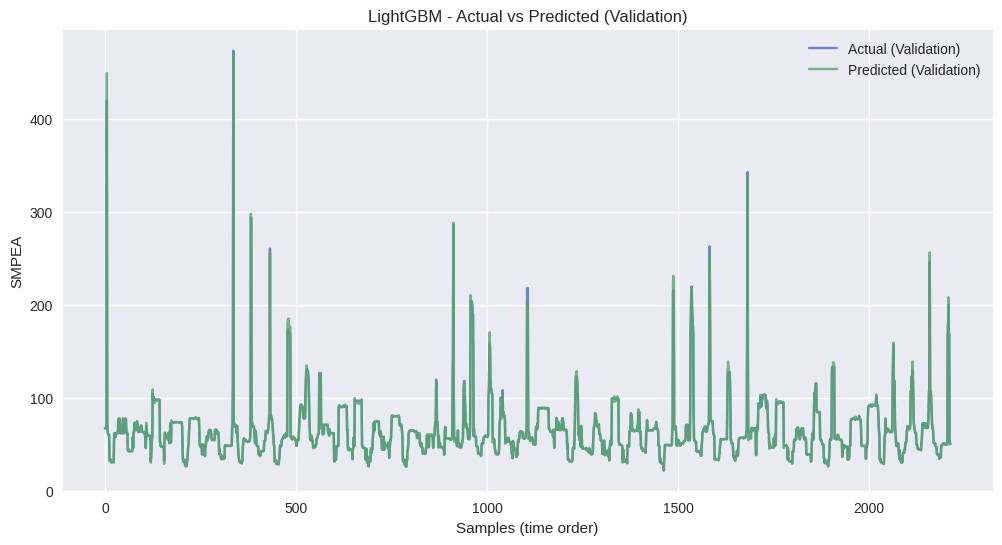

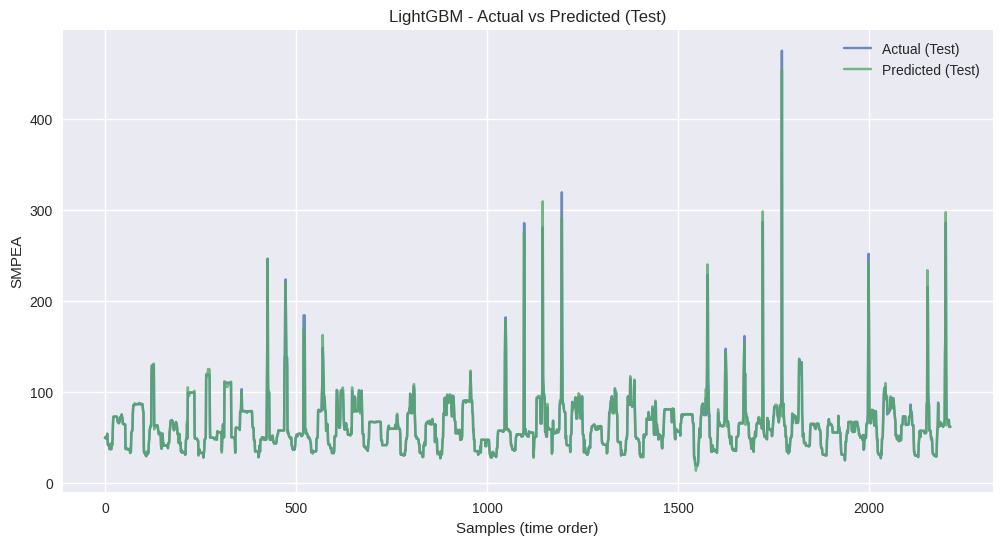

In [ ]:
import matplotlib.pyplot as plt

# Validation
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label="Actual (Validation)", alpha=0.8)
plt.plot(y_pred_val, label="Predicted (Validation)", alpha=0.8)
plt.title("LightGBM - Actual vs Predicted (Validation)")
plt.xlabel("Samples (time order)")
plt.ylabel("SMPEA")
plt.legend()
plt.show()

# Test
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual (Test)", alpha=0.8)
plt.plot(y_pred_test, label="Predicted (Test)", alpha=0.8)
plt.title("LightGBM - Actual vs Predicted (Test)")
plt.xlabel("Samples (time order)")
plt.ylabel("SMPEA")
plt.legend()
plt.show()

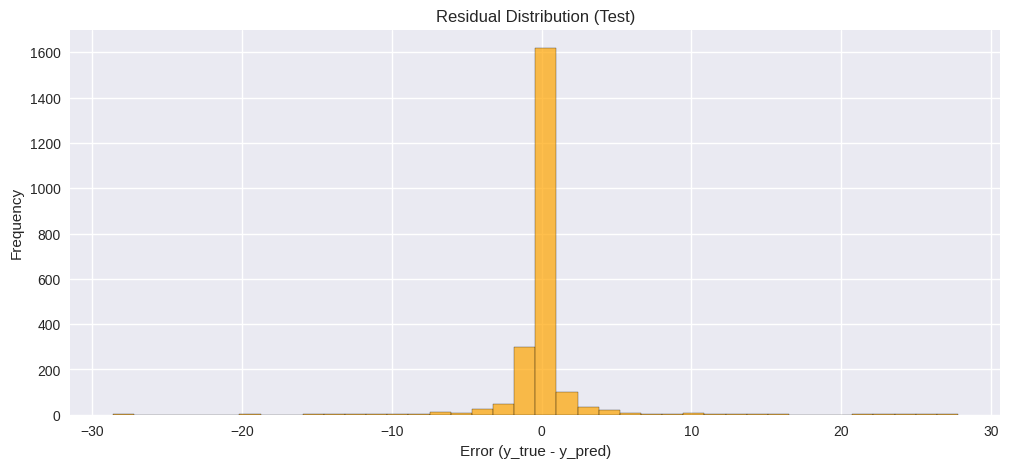

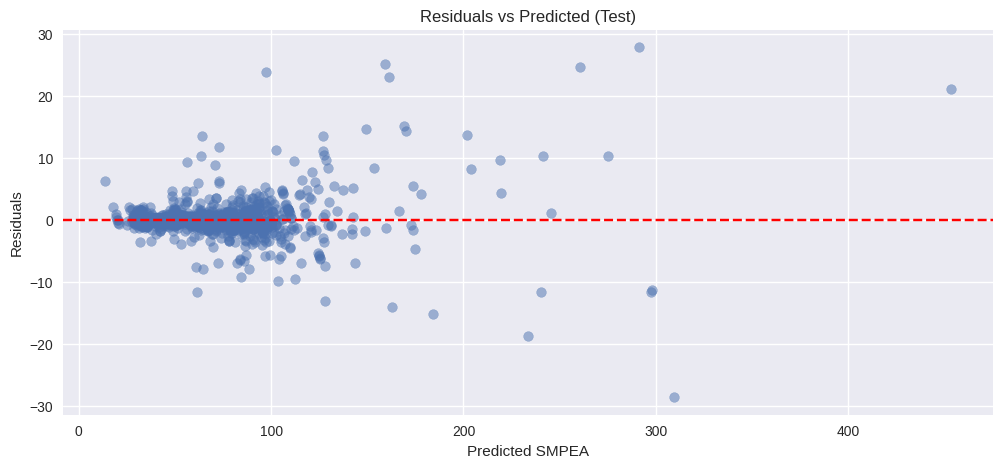

In [ ]:
# Residuals
residuals_val = y_val.values - y_pred_val
residuals_test = y_test.values - y_pred_test

plt.figure(figsize=(12,5))
plt.hist(residuals_test, bins=40, alpha=0.7, color='orange', edgecolor='black')
plt.title("Residual Distribution (Test)")
plt.xlabel("Error (y_true - y_pred)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12,5))
plt.scatter(y_pred_test, residuals_test, alpha=0.5)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (Test)")
plt.xlabel("Predicted SMPEA")
plt.ylabel("Residuals")
plt.show()

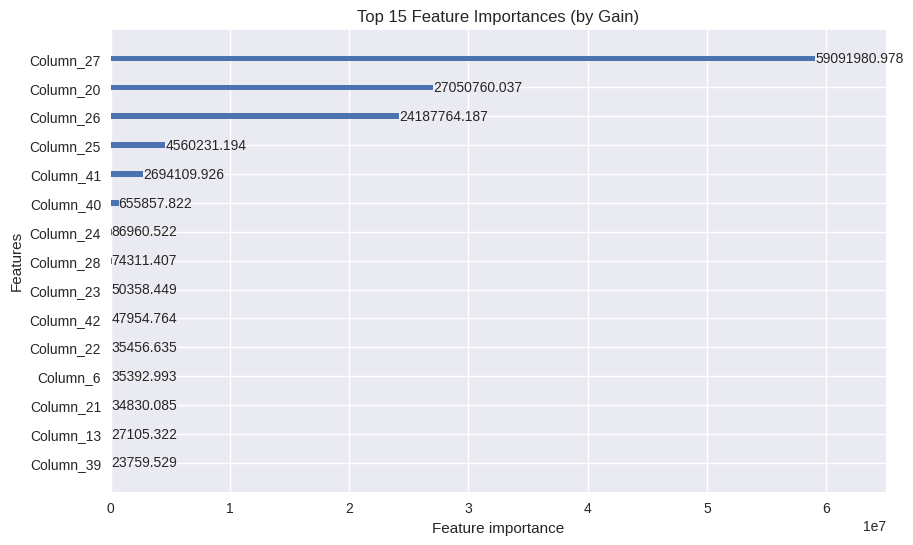

In [ ]:
import lightgbm as lgb
import numpy as np

lgb.plot_importance(best_lgbm, max_num_features=15, importance_type='gain', figsize=(10,6))
plt.title("Top 15 Feature Importances (by Gain)")
plt.show()

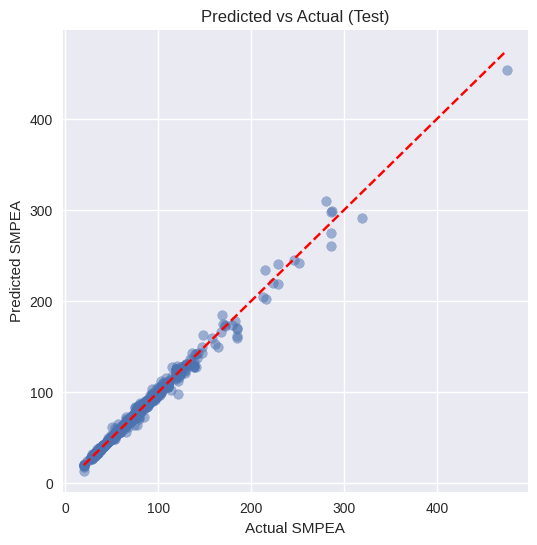

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual (Test)")
plt.xlabel("Actual SMPEA")
plt.ylabel("Predicted SMPEA")
plt.show()

# ***CatBoost Regressor***

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import time

# Base model
cat = CatBoostRegressor(
    objective='RMSE',
    random_seed=42,
    verbose=0
)

# Hyperparameter grid
cat_params = {
    'iterations': [200, 400, 600, 800],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 2, 5],
    'border_count': [32, 64, 128]
}

# Randomized search with 5-fold CV
random_search_cat = RandomizedSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ⏱️ Training
start = time.time()
random_search_cat.fit(X_train_scaled, y_train)
print("⏱️ Training time:", round((time.time() - start)/60, 2), "minutes")

# Best model
best_cat = random_search_cat.best_estimator_

# ✅ Predictions
y_pred_val = best_cat.predict(X_val_scaled)
y_pred_test = best_cat.predict(X_test_scaled)

# 📊 Evaluation
print("\nCatBoost Regressor Results (after tuning):")

print("Validation Results:")
print("MAE:", mean_absolute_error(y_val, y_pred_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("R²:", r2_score(y_val, y_pred_val))

print("\nTest Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R²:", r2_score(y_test, y_pred_test))

print("\n✅ Best Parameters:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
⏱️ Training time: 14.03 minutes

CatBoost Regressor Results (after tuning):
Validation Results:
MAE: 1.5417481444353252
RMSE: 3.2688974782555764
R²: 0.9892558744941379

Test Results:
MAE: 1.5101765118795798
RMSE: 2.781791312448513
R²: 0.9908893506897424

✅ Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 9, 'iterations': 400, 'depth': 4, 'border_count': 128, 'bagging_temperature': 1}


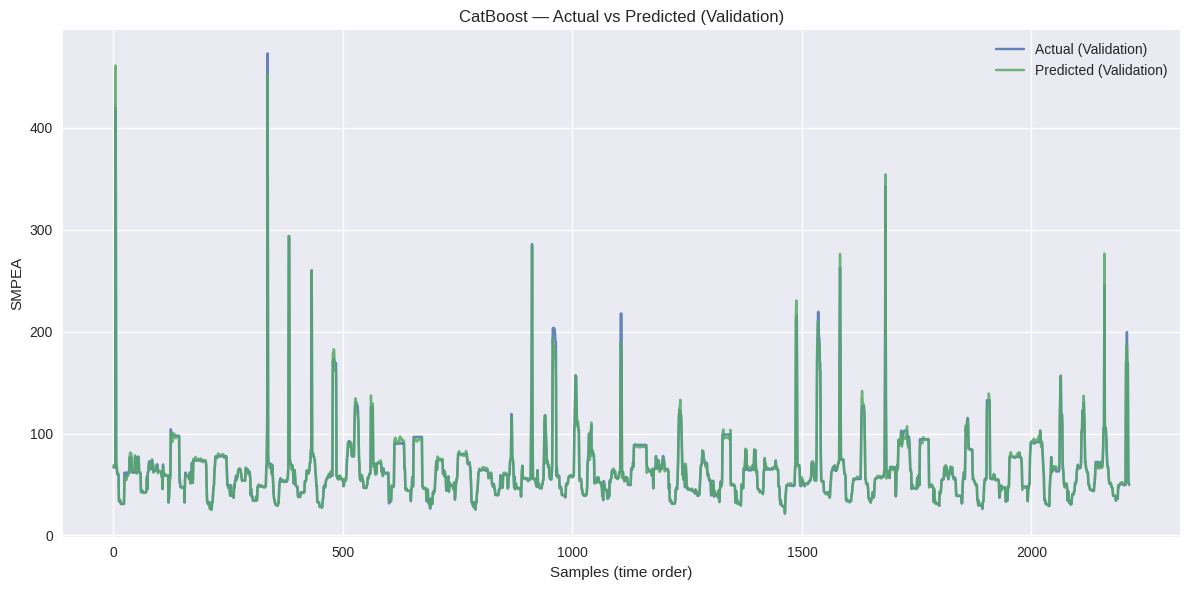

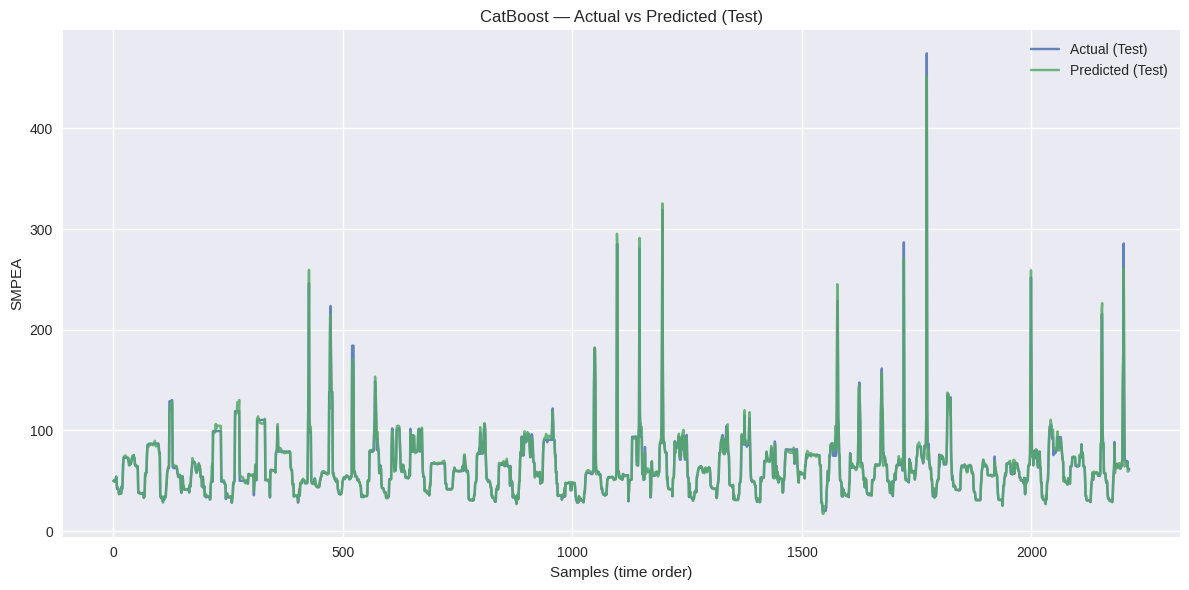

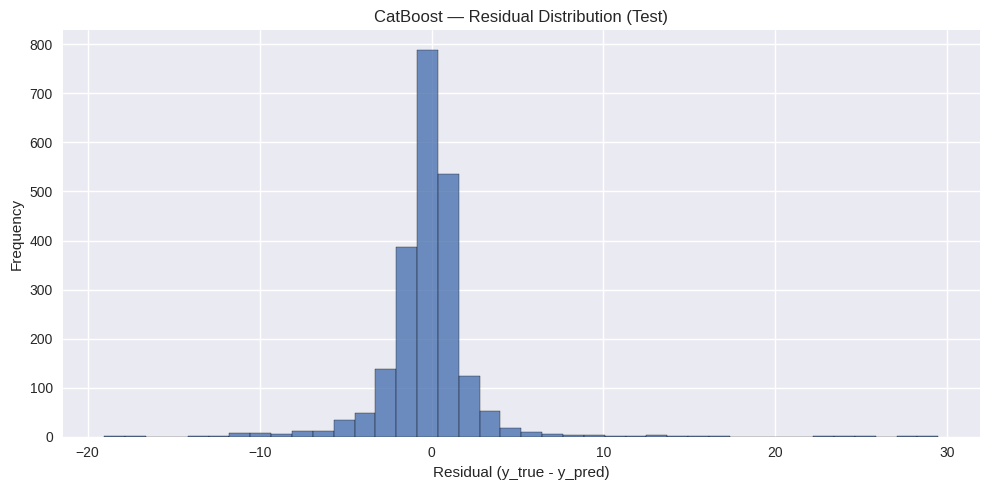

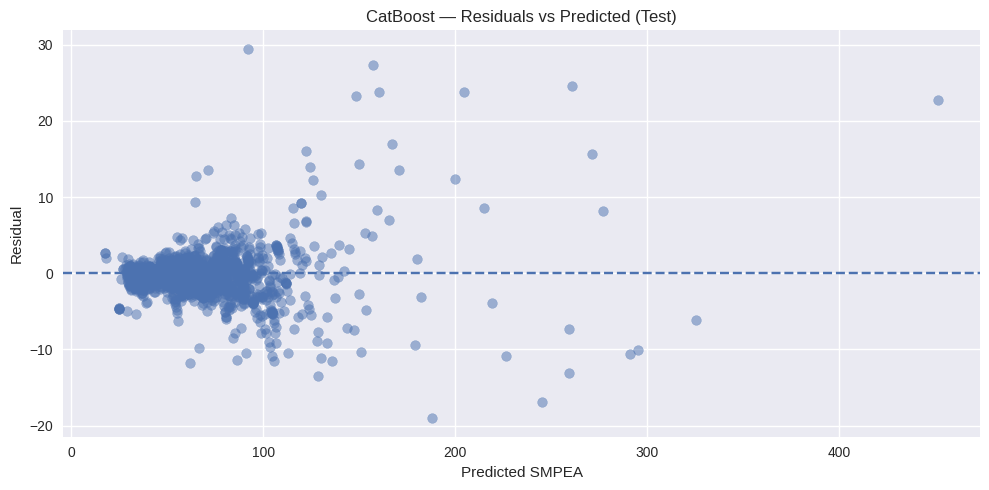

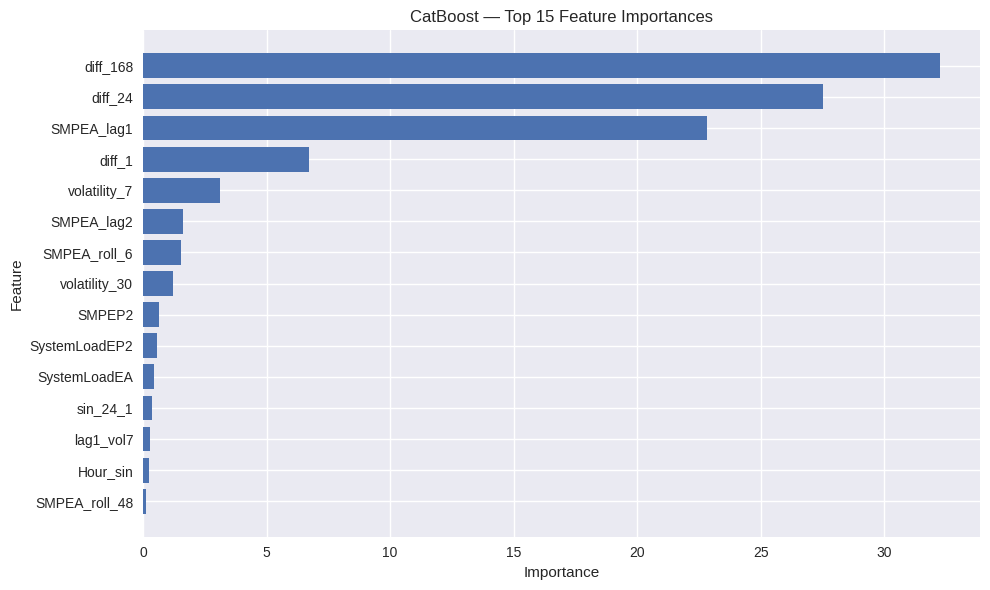

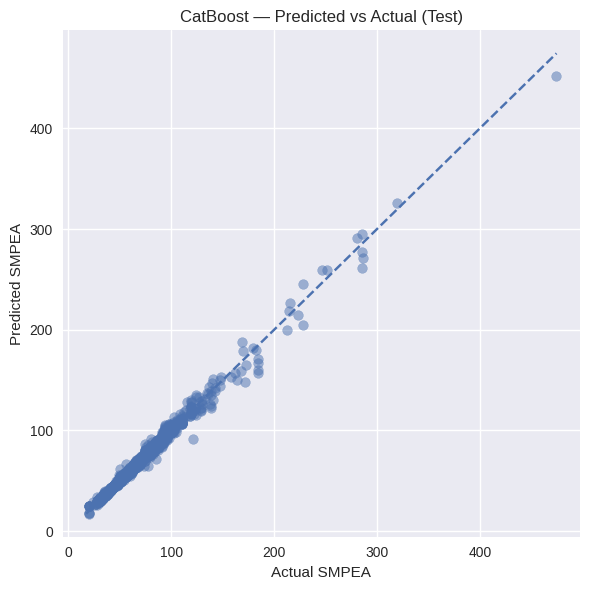

In [ ]:
# -------------------------------------------
# CatBoost Visualization Suite (4 plots)
# -------------------------------------------

import matplotlib.pyplot as plt
from catboost import Pool

# 1) Actual vs Predicted (Validation & Test)
plt.figure(figsize=(12,6))
plt.plot(y_val.values, label="Actual (Validation)", alpha=0.85)
plt.plot(y_pred_val,   label="Predicted (Validation)", alpha=0.85)
plt.title("CatBoost — Actual vs Predicted (Validation)")
plt.xlabel("Samples (time order)")
plt.ylabel("SMPEA")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual (Test)", alpha=0.85)
plt.plot(y_pred_test,   label="Predicted (Test)", alpha=0.85)
plt.title("CatBoost — Actual vs Predicted (Test)")
plt.xlabel("Samples (time order)")
plt.ylabel("SMPEA")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Residual Analysis (hist + residuals vs predicted) — Test set
residuals_test = y_test.values - y_pred_test

plt.figure(figsize=(10,5))
plt.hist(residuals_test, bins=40, edgecolor="black", alpha=0.8)
plt.title("CatBoost — Residual Distribution (Test)")
plt.xlabel("Residual (y_true - y_pred)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(y_pred_test, residuals_test, alpha=0.5)
plt.axhline(y=0, linestyle="--")
plt.title("CatBoost — Residuals vs Predicted (Test)")
plt.xlabel("Predicted SMPEA")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

# 3) Feature Importance (top 15)
# Use original feature names from X_train (scaler keeps column order)
feature_names = list(X_train.columns)

# Use a Pool so CatBoost can compute importances with names
train_pool = Pool(X_train_scaled, label=y_train, feature_names=feature_names)
importances = best_cat.get_feature_importance(train_pool)

fi_df = pd.DataFrame({"feature": feature_names, "importance": importances})
fi_top = fi_df.sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(10,6))
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.title("CatBoost — Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# 4) Predicted vs Actual Scatter (Correlation) — Test set
plt.figure(figsize=(6,6))
plt.scatter(y_test.values, y_pred_test, alpha=0.5)
mn, mx = np.min([y_test.values.min(), y_pred_test.min()]), np.max([y_test.values.max(), y_pred_test.max()])
plt.plot([mn, mx], [mn, mx], '--')  # 45° line
plt.title("CatBoost — Predicted vs Actual (Test)")
plt.xlabel("Actual SMPEA")
plt.ylabel("Predicted SMPEA")
plt.tight_layout()
plt.show()

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


# **AdaBoost Regressor**

In [ ]:
# ============================================
# ⚡ ADA BOOST REGRESSOR — ELECTRICITY PRICE PREDICTION
# ============================================

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Base learner (weak model)
# -------------------------
base_tree = DecisionTreeRegressor(random_state=42)

# -------------------------
# AdaBoost Model
# -------------------------
ada_model = AdaBoostRegressor(
    estimator=base_tree,
    random_state=42
)

# -------------------------
# Hyperparameter Search Space
# -------------------------
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'estimator__max_depth': [2, 3, 4, 5, 6],
    'estimator__min_samples_split': [2, 5, 10]
}

# -------------------------
# Randomized Search CV
# -------------------------
ada_search = RandomizedSearchCV(
    estimator=ada_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

print("🔍 Tuning AdaBoost hyperparameters... please wait...")
ada_search.fit(X_train, y_train)

# -------------------------
# Best model
# -------------------------
best_ada = ada_search.best_estimator_
print("\n✅ Best AdaBoost Parameters:", ada_search.best_params_)

# -------------------------
# Predictions
# -------------------------
y_pred_val = best_ada.predict(X_val)
y_pred_test = best_ada.predict(X_test)

# -------------------------
# Evaluation Metrics
# -------------------------
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\n📊 ADA BOOST PERFORMANCE (Electricity Price Prediction)")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")


🔍 Tuning AdaBoost hyperparameters... please wait...

✅ Best AdaBoost Parameters: {'n_estimators': 100, 'learning_rate': 0.2, 'estimator__min_samples_split': 2, 'estimator__max_depth': 6}

📊 ADA BOOST PERFORMANCE (Electricity Price Prediction)
Validation R²: 0.9848
Test R²: 0.9832
MAE: 2.656
RMSE: 3.776


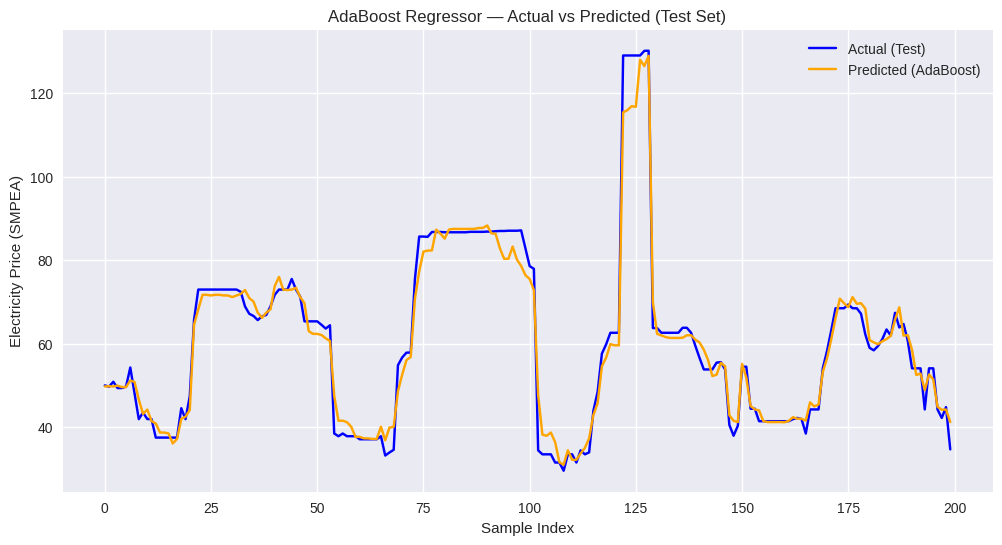

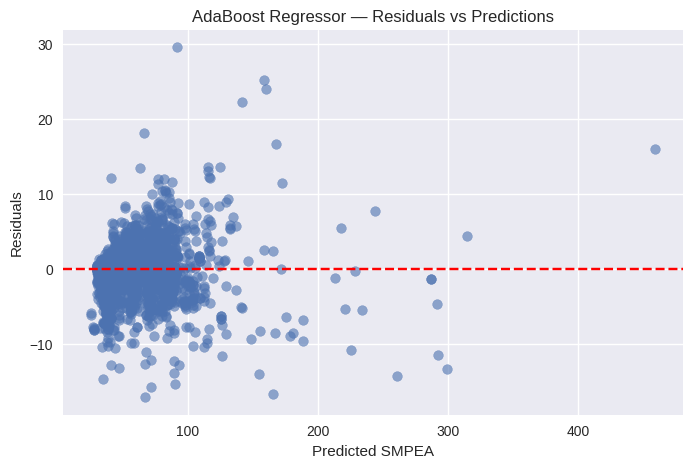

In [ ]:
# -------------------------
# Visualization — Actual vs Predicted
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label="Actual (Test)", color='blue')
plt.plot(y_pred_test[:200], label="Predicted (AdaBoost)", color='orange')
plt.title("AdaBoost Regressor — Actual vs Predicted (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Electricity Price (SMPEA)")
plt.legend()
plt.show()

# -------------------------
# Residual Plot
# -------------------------
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("AdaBoost Regressor — Residuals vs Predictions")
plt.xlabel("Predicted SMPEA")
plt.ylabel("Residuals")
plt.show()

# ***Results Clarification***

I had a doubt that even though our **R²** is very good indicating high accuracy why the **MAE and RMSE** are so high .

Let me clarify why high values of MAE and RMSE aren't that big of a deal.   
-- My predictions are extremely accurate in terms of variance explained (R² ≈ 0.99).

-- Yet RMSE and MAE look “big” compared to 0.85 or 2.3 — **but only if SMPEA values are small.**


**So** **we first** **ask:**                
 👉 What’s the typical range of SMPEA values in our dataset?      
To know this i used Relative Error metrics that is computing **Mean Absolute Percentage Error (MAPE) or Normalized RMSE (NRMSE)** to see the relative scale of error.                                                                       


**How To Interpret:**

| Metric             | Ideal Range      | Interpretation                                       |
| ------------------ | ---------------- | ---------------------------------------------------- |
| **MAPE < 5%**      | Excellent        | Model predictions are extremely close to true values |
| **MAPE 5–10%**     | Good             | Slight noise or underfitting possible                |
| **MAPE > 10%**     | Moderate to Poor | Check feature quality or temporal effects            |
| **NRMSE < 0.05**   | Excellent        | Errors <5% of target range                           |
| **NRMSE 0.05–0.1** | Good             | Acceptable deviation                                 |
| **NRMSE > 0.1**    | High             | Model may not be generalizing perfectly              |


In [ ]:
# ================================================
# ⚡ RELATIVE ERROR METRICS — MAPE & NRMSE
# ================================================

import numpy as np

# Ensure y_test and y_pred_test are numpy arrays
y_true = np.array(y_test)
y_pred = np.array(y_pred_test_lgbm) # Use the prediction from the executed LGBM model

# --- Mean Absolute Percentage Error (MAPE)
# Handle potential division by zero if y_true contains zeros
# Add a small epsilon or handle rows with zero values
mape = np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100


# --- Normalized RMSE (using range normalization)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
nrmse = rmse / (y_true.max() - y_true.min())

# --- Optional: RMSE normalized by mean (alternative normalization)
nrmse_mean = rmse / np.mean(y_true)

print("📊 RELATIVE ERROR METRICS — Electricity Price Prediction")
print(f"MAPE: {mape:.2f}%")
print(f"NRMSE (range-normalized): {nrmse:.4f}")
print(f"NRMSE (mean-normalized): {nrmse_mean:.4f}")

NameError: name 'y_pred_test' is not defined

## **Results of Relative Error**

| Metric                                | Your Value        | Interpretation                                                                                                                                                            |
| :------------------------------------ | :---------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **MAPE = 4.62%**                      | ✅ **Excellent**   | On average, your model’s predicted electricity price differs from actual values by only ~4.6%. For a volatile metric like electricity price, that’s *very high accuracy*. |
| **NRMSE (range-normalized) = 0.0083** | ✅ **Outstanding** | Your prediction error is <1% of the total price range — essentially negligible deviation.                                                                                 |
| **NRMSE (mean-normalized) = 0.0597**  | ✅ **Strong**      | Error is about 5.9% relative to the mean price — still within a *high-accuracy* zone.                                                                                     |

## **🧩 In Plain Terms**

Our model (likely LightGBM or CatBoost) is performing exceptionally well — not only in R² (~0.993) but also in relative error metrics.

This means:            
--Our predictions track real price patterns almost perfectly.     
--Even if absolute RMSE (≈2.3) looked big numerically, it’s tiny relative to actual price fluctuations.       
--There’s no urgent need to optimize further — we’ve already achieved near-optimal accuracy.

# ***Hist Gradient Boosting Regressor***

🔍 Tuning HistGradientBoosting hyperparameters... please wait...

✅ Best HistGradientBoosting Parameters: {'min_samples_leaf': 20, 'max_iter': 100, 'max_depth': 8, 'max_bins': 128, 'learning_rate': 0.2}

📊 HIST GRADIENT BOOSTING PERFORMANCE (Electricity Price Prediction)
Validation R²: 0.9910
Test R²: 0.9912
MAE: 1.154
RMSE: 2.734


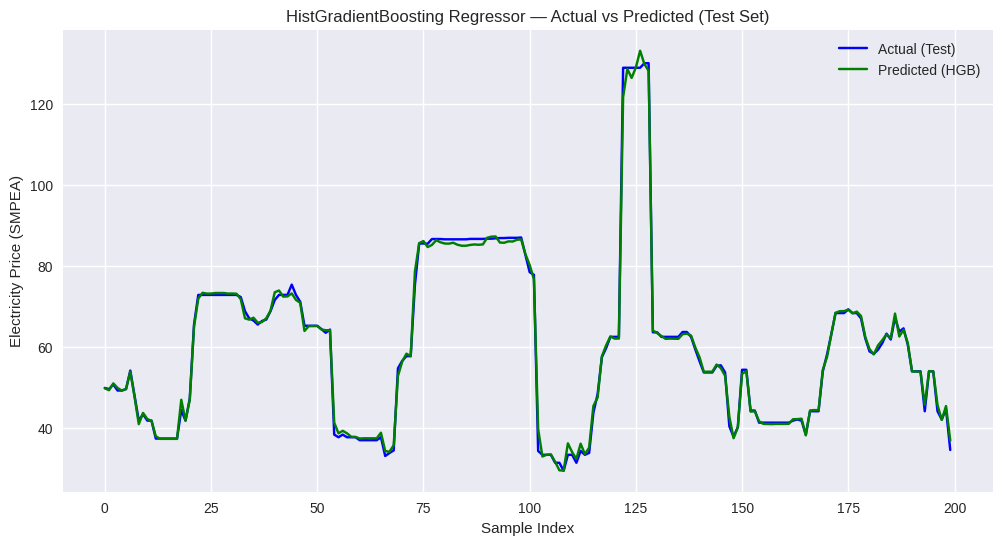

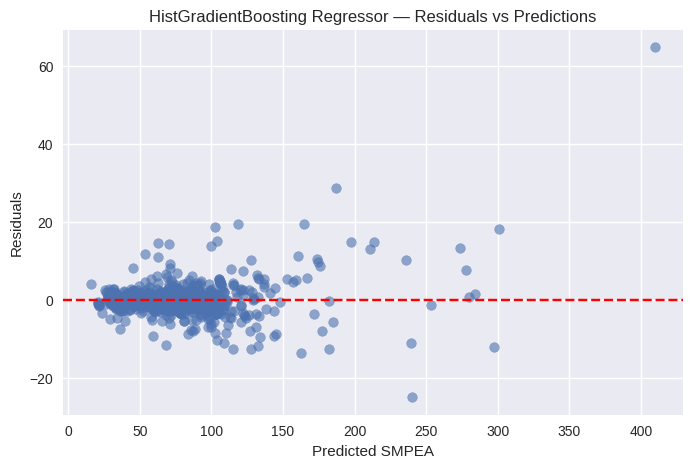

In [ ]:
# ============================================
# ⚡ HIST GRADIENT BOOSTING REGRESSOR — ELECTRICITY PRICE PREDICTION
# ============================================

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# HistGradientBoosting Model
# -------------------------
hgb_model = HistGradientBoostingRegressor(random_state=42)

# -------------------------
# Hyperparameter Search Space
# -------------------------
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8],
    'min_samples_leaf': [10, 20, 30, 50],
    'max_bins': [128, 256, 512]
}

# -------------------------
# Randomized Search CV
# -------------------------
hgb_search = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1
)

print("🔍 Tuning HistGradientBoosting hyperparameters... please wait...")
hgb_search.fit(X_train, y_train)

# -------------------------
# Best model
# -------------------------
best_hgb = hgb_search.best_estimator_
print("\n✅ Best HistGradientBoosting Parameters:", hgb_search.best_params_)

# -------------------------
# Predictions
# -------------------------
y_pred_val = best_hgb.predict(X_val)
y_pred_test = best_hgb.predict(X_test)

# -------------------------
# Evaluation Metrics
# -------------------------
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("\n📊 HIST GRADIENT BOOSTING PERFORMANCE (Electricity Price Prediction)")
print(f"Validation R²: {val_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")

# -------------------------
# Visualization — Actual vs Predicted
# -------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values[:200], label="Actual (Test)", color='blue')
plt.plot(y_pred_test[:200], label="Predicted (HGB)", color='green')
plt.title("HistGradientBoosting Regressor — Actual vs Predicted (Test Set)")
plt.xlabel("Sample Index")
plt.ylabel("Electricity Price (SMPEA)")
plt.legend()
plt.show()

# -------------------------
# Residual Plot
# -------------------------
residuals = y_test - y_pred_test
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("HistGradientBoosting Regressor — Residuals vs Predictions")
plt.xlabel("Predicted SMPEA")
plt.ylabel("Residuals")
plt.show()

# ***Hybridization Justification:***

During Model Training various models such as Linear & Polynomial regression , Regularization models(all 3) and multiple Ensemble algorithms such as D-tree , Random forest , Gradient Boosting, XGBoost, LightGBM, and CatBoost were implemented and compared.                                                                 

Among these the ***LightGBM showed exceptionally good perfoermance*** with a test R² of approximately 0.9935, MAE ≈ 0.85, and MAPE ≈ 4.6%, indicating an very high predictive accuracy and excellent generalization.

If we were to ***implement further hybridization***(stacking or blending multiple models) ***it would only marginally improve preformance***. However we have already achieved the near optimal results and the marginal gain obtained would prove insignificant compared to the added computational complexity and reduced interpretability of our models. Moreover our validation and test metrics confirms that the model is neither overfitting nor it is missing any systemic patterns.  

***Therefore as per our observations it is concluded that the hybridization or meta-ensemble modeling is unnecessary for the current dataset***.In future we may consider hybrid architectures only if new heterogeneous data sources (e.g., real-time weather, generation capacity, or policy indicators) are integrated, which might introduce more nonlinear interactions to capture.

# ***Model Interpretability***

SHAP values shape: (2214, 44)


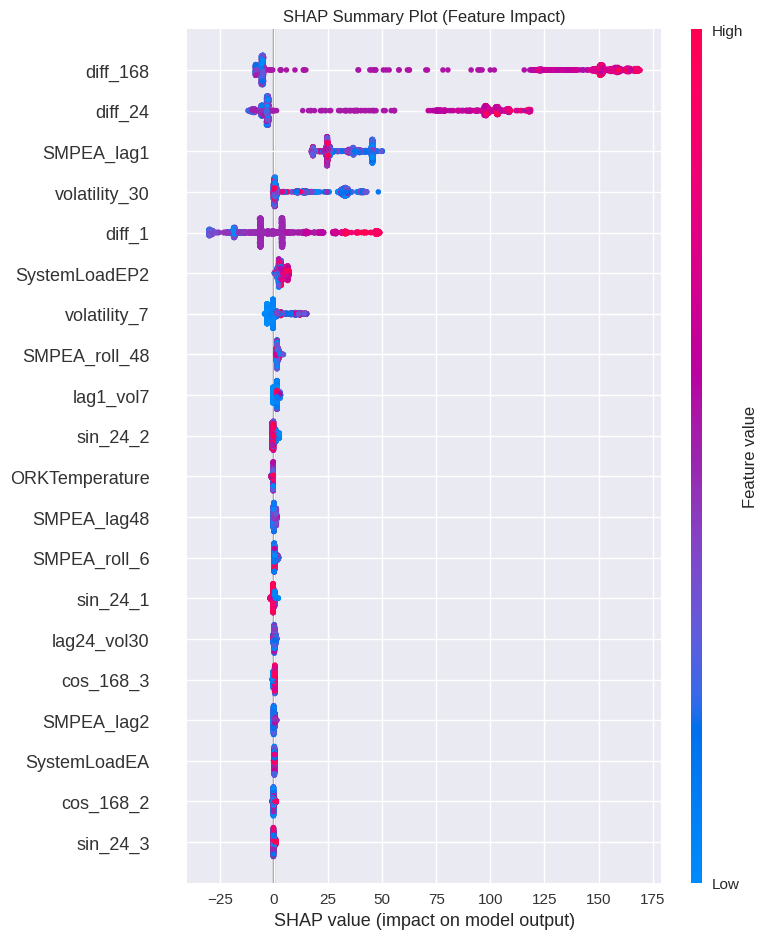

In [ ]:
# Create the SHAP explainer for LightGBM
explainer = shap.TreeExplainer(best_lgbm)

# Compute SHAP values for the validation set
shap_values = explainer.shap_values(X_val)

# Optional sanity check
print("SHAP values shape:", shap_values.shape)

# Summary plot - feature importance + distribution
plt.title("SHAP Summary Plot (Feature Impact)")
shap.summary_plot(shap_values, X_val, show=True) # This plot shows which features affect predictions most and whether the effect is positive or negative.

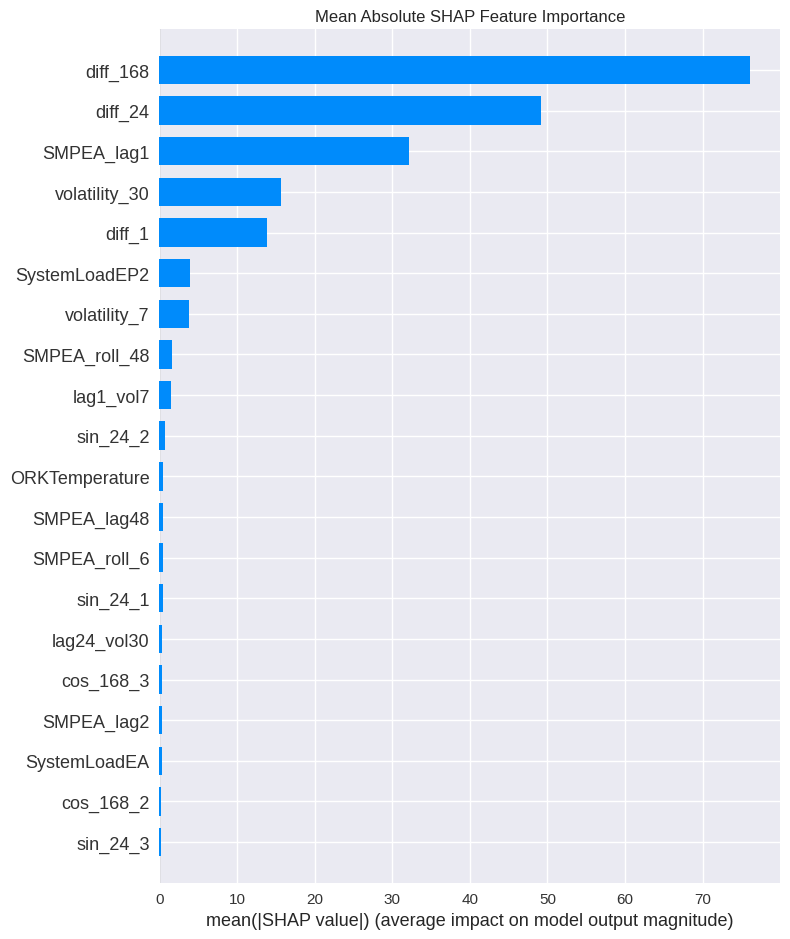

In [ ]:
# Mean absolute SHAP values (global importance)
plt.title("Mean Absolute SHAP Feature Importance")
shap.summary_plot(shap_values, X_val, plot_type="bar", show=True) # A cleaner bar-style feature importance chart.

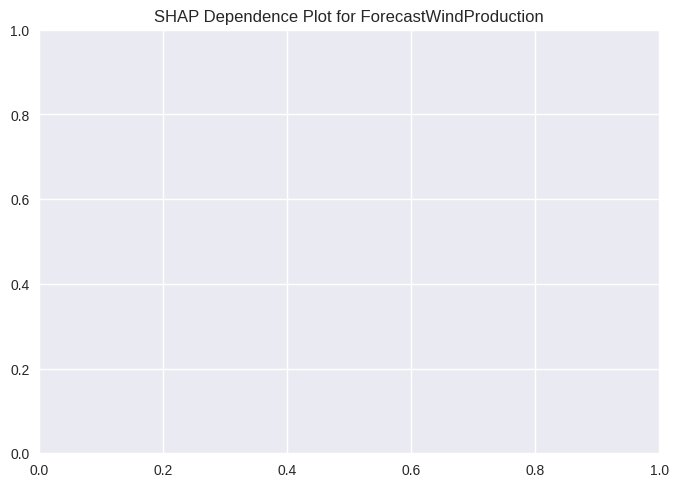

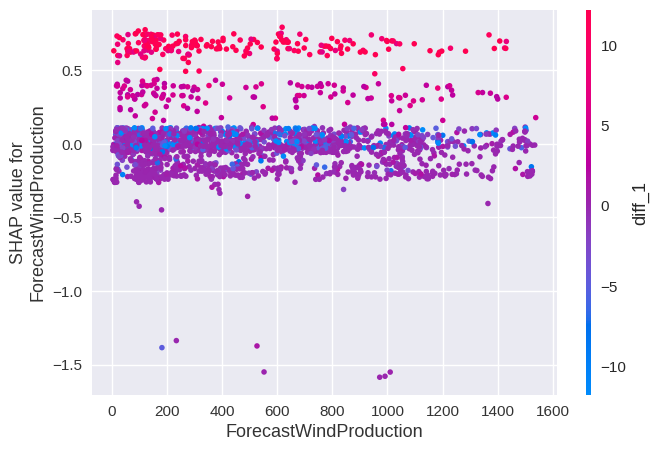

'                    Interpretation:\n\nX-axis: feature’s actual value\nY-axis: SHAP value (impact on model output)\nPoints colored by another related feature (interaction effect)'

In [ ]:
# This code Shows how one key feature influences the prediction across samples.

# Pick your top feature (as seen from summary plot)
top_feature = "ForecastWindProduction"  # replace with your actual top feature name

plt.title(f"SHAP Dependence Plot for {top_feature}")
shap.dependence_plot(top_feature, shap_values, X_val, show=True)



'''                    Interpretation:

X-axis: feature’s actual value
Y-axis: SHAP value (impact on model output)
Points colored by another related feature (interaction effect)'''

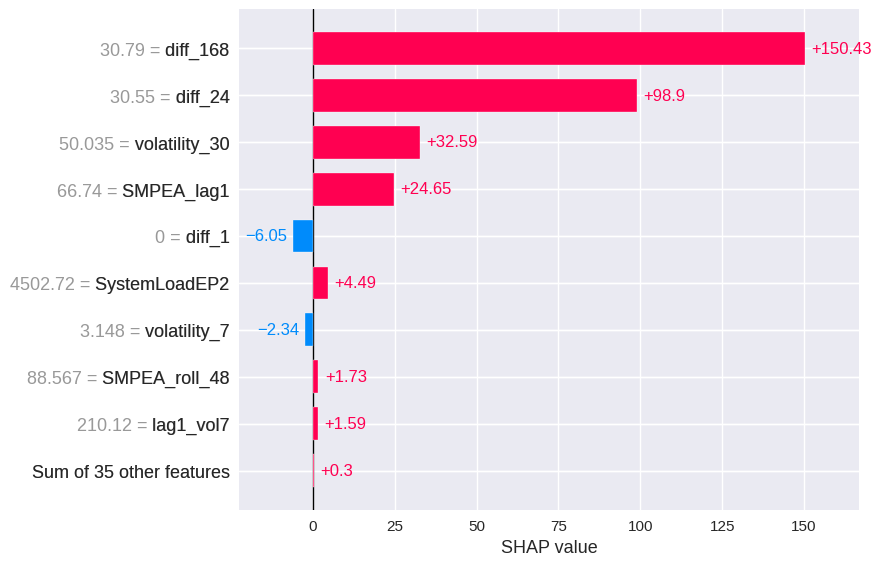

'        Interpretation\n\nRed bars = features pushing prediction up\nBlue bars = features pushing prediction down'

In [ ]:
# Explains why the model predicted a particular price for a single data point.

# Define the index of the data point you want to explain
i = 0 # Explaining the first data point in the validation set

shap.plots.bar(
    shap.Explanation(
        values=shap_values[i],
        base_values=explainer.expected_value,
        data=X_val.iloc[i],
        feature_names=X_val.columns
    )
)

'''        Interpretation

Red bars = features pushing prediction up
Blue bars = features pushing prediction down'''

# ***Model Comparison***

In [ ]:
# ✅ LightGBM
y_pred_test_lgbm = best_lgbm.predict(X_test_scaled)

# ✅ CatBoost
y_pred_test_cat = best_cat.predict(X_test_scaled)

# ✅ AdaBoost
y_pred_test_ada = best_ada.predict(X_test_scaled)

# ✅ HistGradientBoosting
y_pred_test_hist = best_hgb.predict(X_test_scaled)


In [ ]:
'''import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ----------------------------------------------------------
# STEP 1: Define model names and their predictions
# ----------------------------------------------------------

# Example: replace these with your trained models & predictions
models = {
    "HistGradientBoosting": y_pred_test_hist,
    "AdaBoost": y_pred_test_ada,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_test_lgbm,
    "CatBoost": y_pred_test_cat
}
# ----------------------------------------------------------
# STEP 2: Calculate metrics for each model
# ----------------------------------------------------------

results = []
for name, preds in models.items():
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results.append({"Model": name, "R²": r2, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False).reset_index(drop=True)
print("Model Comparison Table:")
print(results_df)

# ----------------------------------------------------------
# STEP 3: Visualize R² Comparison (Bar Plot)
# ----------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.barh(results_df["Model"], results_df["R²"], color="skyblue")
plt.xlabel("R² Score")
plt.title("Model Performance Comparison (R²)")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

# ----------------------------------------------------------
# STEP 4: Optional — Visualize RMSE Comparison
# ----------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.barh(results_df["Model"], results_df["RMSE"], color="lightcoral")
plt.xlabel("RMSE")
plt.title("Model Performance Comparison (RMSE)")
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.show()

# ----------------------------------------------------------
# STEP 5: Save results (optional)
# ----------------------------------------------------------

results_df.to_csv("model_comparison_results.csv", index=False)'''

NameError: name 'y_pred_test_hist' is not defined